# Get estimate of named entities
In which we estimate how frequent it is to see an ambiguous named entity in our collected data.

In [14]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import re

In [15]:
# load harvey/irma data
combined_tweet_f_name = '../../data/mined_tweets/#Irma,#Harvey,#HurricaneIrma,#HurricaneHarvey_combined_data.tsv'
tweet_data = pd.read_csv(combined_tweet_f_name, sep='\t', index_col=0)
# fix start/end quotes
quote_matcher = re.compile('^"+|"+$')
tweet_data = tweet_data.assign(text=tweet_data.loc[:, 'text'].apply(lambda x: quote_matcher.sub('', str(x)).replace('\n', '')))
print(tweet_data.head())

   index       username                                               text  \
0    1.0    westpalmbch  NOW: I-95 in West Palm Beach. Hurricane warnin...   
1    2.0  OfficialJoelF  Meanwhile in Hialeah #Irma (Cred: @Armani_Blan...   
2    3.0   AfricanaCarr  Yemaja and Osun, guide the people of #Cuba #Fl...   
3    4.0  WeatherNation  NEW: This video was shot just minutes ago of a...   
4    5.0            ABC  LATEST: Hurricane #Irma now 105 miles SE of Ke...   

   geo            id retweet_count  favorite_count place_name  \
0  NaN  9.064888e+17            42            54.0        NaN   
1  NaN  9.066287e+17          1662          1975.0        NaN   
2  NaN  9.066582e+17            12            34.0        NaN   
3  NaN  9.066637e+17           242           227.0        NaN   
4  NaN  9.066576e+17           368           341.0        NaN   

            created_at  
0  2017-09-09 08:05:00  
1  2017-09-09 17:21:00  
2  2017-09-09 19:18:00  
3  2017-09-09 19:40:00  
4  2017-09-09 1

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0,4,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Try named entity recognizer
[This one](https://github.com/aritter/twitter_nlp) first because it's easy to use out of the box.

Command line argument:

`python python/ner/extractEntities.py test.1k.txt -o output.txt`

We need to write tweet text to a dummy file temporarily.

Clean up the text to raise chances of catching entities.

In [19]:
# remove hyperlinks and duplicates
tweet_txt = tweet_data.loc[:, 'text']
url_matcher = re.compile('http://\w+|pic.twitter.com/\w+')
print(tweet_txt.apply(lambda x: url_matcher.sub('', x)).values.tolist()[:5])

['NOW: I-95 in West Palm Beach. Hurricane warning and curfew are in effect. #HurricaneIrma ', 'Meanwhile in Hialeah #Irma (Cred: @Armani_Blanco ) ', 'Yemaja and Osun, guide the people of #Cuba #Florida and the entire region as #HurricaneIrma continues to move.', 'NEW: This video was shot just minutes ago of a possible #tornado in Fort Lauderdale, Florida\xe2\x80\x8b. #Irma ', 'LATEST: Hurricane #Irma now 105 miles SE of Key West; Tropical storm conditions now occurring in Florida Keys. http:// abcn.ws/2vWqpYv ']


In [118]:
tmp_file = combined_tweet_f_name.replace('.tsv', '_txt.tsv')
tweet_txt.to_csv(tmp_file, index=False)

Update! We can't get this command to run from Python so we had to make a custom extraction script [here](../../lib/twitter_nlp/extract_entities.sh) to run from that directory. MESS.

## Load labelled text

In [2]:
tweet_txt_entities = [l.strip() for l in open('../../data/mined_tweets/#Irma,#Harvey,#HurricaneIrma,#HurricaneHarvey_combined_data_txt_ner.tsv')]
print(tweet_txt_entities[:20])

['NOW/O :/O I-95/O in/O West/B-ENTITY Palm/I-ENTITY Beach/I-ENTITY ./O Hurricane/O warning/O and/O curfew/O are/O in/O effect/O ./O #HurricaneIrma/O pic.twitter.com/DOt09uiXqJ/O', 'Meanwhile/O in/O Hialeah/B-ENTITY #Irma/O (/O Cred/O :/O @Armani_Blanco/O )/O pic.twitter.com/IgCL7WzIes/O', '"/O Yemaja/O and/O Osun/B-ENTITY ,/O guide/O the/O people/O of/O #Cuba/O #Florida/O and/O the/O entire/O region/O as/O #HurricaneIrma/O continues/O to/O move/O ."/O', '"/O NEW/O :/O This/O video/O was/O shot/O just/O minutes/O ago/O of/O a/O possible/O #tornado/O in/O Fort/B-ENTITY Lauderdale/I-ENTITY ,/O Florida\xe2\x80\x8b/B-ENTITY ./O #Irma/O pic.twitter.com/rcBP8tV36M/O "/O', 'LATEST/O :/O Hurricane/O #Irma/O now/O 105/O miles/O SE/O of/O Key/B-ENTITY West/I-ENTITY ;/O Tropical/O storm/O conditions/O now/O occurring/O in/O Florida/B-ENTITY Keys/I-ENTITY ./O http:///O abcn/O ./O ws/2vWqpYv/O pic.twitter.com/WejKQhA7IB/O', "Got/O this/O from/O a/O reader/O ./O Why/O didn't/O I/O think/O of/O that/O

Let's see what entities were most frequent.

In [145]:
import pandas as pd
import re
from collections import Counter
txt_split = lambda x: map(lambda y: y.split('/'), x.split(' '))
entity_matcher = re.compile('[BI]-ENTITY')
entity_filter = lambda x: entity_matcher.match(x)
# we want to find entities based on consecutive tags!
# simple assumption: no adjacent entities
def find_entities(x):
    entity_list = []
    current_entity = []
    # remove triplets (usually URLs)
    token_tags = filter(lambda x: len(x)==2, txt_split(x))
    for token, tag in token_tags:
        if(entity_filter(tag)):
            current_entity.append(token)
        elif(len(current_entity) > 0):
            current_entity_str = ' '.join(current_entity)
            entity_list.append(current_entity_str)
            current_entity = []
    return entity_list
entities_per_tweet = map(find_entities, tweet_txt_entities)
print(len(entity_list))
entity_list = reduce(lambda x,y: x+y, entities_per_tweet)
# # strip tags
entity_counts = pd.Series(Counter(entity_list)).sort_values(inplace=False, ascending=False)

100


In [146]:
print(entity_counts.head(20))
print(entity_counts.tail(20))
print('%d unique entities'%(len(entity_counts)))

Florida           17907
Texas              7131
Cuba               5768
Miami              5762
Irma               5376
Houston            5319
Hurricane          3395
FL                 2666
Trump              2365
Hurricane Irma     2240
#Harvey            1708
Key West           1680
Tampa              1519
TX                 1360
Kappa Sig          1224
#Irma              1199
Puerto Rico        1114
Twitter            1108
America            1063
Harvey             1024
dtype: int64
Koch brothers begged Trump       1
Kleiner Reminder                 1
Kleine Antillen                  1
Kirwan Terrance                  1
Kite Surfers                     1
Kirwan Terrance Ballpark         1
Kiss Ass Jed                     1
Kissam                           1
Tampa-Orlando                    1
Kissimmee Muscle                 1
Kite                             1
Kitts                            1
Klein ISD Multipurpose Center    1
Kitty Haven                      1
Kitty Hawk       

OK! These entities make sense because they're mostly locations where Harvey and Irma hit.

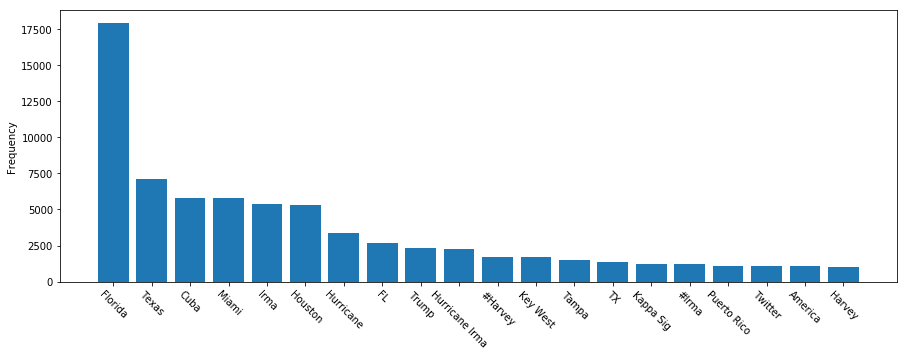

In [160]:
# bar chart of top 20
top_k = 20
x_pos = pd.np.arange(top_k)
tick_width = 0.75
plt.figure(figsize=(top_k * tick_width, 5))
plt.bar(x_pos, entity_counts.head(top_k))
plt.xticks(x_pos, entity_counts.head(top_k).index, rotation=315)
plt.ylabel('Frequency')
plt.show()

## Entity summary

How many tweets contain at least one entity?

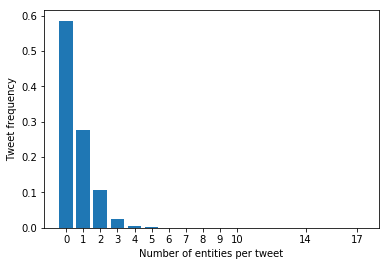

In [162]:
tweet_entity_counts = pd.Series(map(len, entities_per_tweet)).value_counts()
tweet_entity_counts /= tweet_entity_counts.sum()
plt.bar(tweet_entity_counts.index, tweet_entity_counts)
plt.xlabel('Number of entities per tweet')
plt.ylabel('Tweet frequency')
plt.xticks(tweet_entity_counts.index, tweet_entity_counts.index)
# plt.yscale('log')
plt.show()

Most tweets have no entities, and those that have entities only have a few.

**SKIP** because bash commands from Python don't execute properly.

In [112]:
# python code executes but NOTHING HAPPENS for anything more complicated than ls ;_; ;_;
import subprocess
from subprocess import Popen, PIPE
import osa
tmp_file_cmd = tmp_file
ner_script_file = '../../lib/twitter_nlp/python/ner/extractEntities.py'
command = 'python %s %s -o %s.NER'%(ner_script_file, tmp_file, tmp_file)
# command = 'ls -halt %s'%(tmp_file_cmd)
process = Popen(command.split(), stdout=PIPE)
output, error = process.communicate()
print(output)

## Query DBPedia
Now that we have entities, we need to know how ambiguous they are.

We want to query DBPedia to determine ambiguity based on the number of articles that match the entity based on string-initial occurrence.

In [20]:
sample_size = 100
entities_to_query = entity_counts.index.tolist()[:sample_size]
print('/'.join(entities_to_query))

Florida/Texas/Cuba/Miami/Irma/Houston/Hurricane/FL/Trump/Hurricane Irma/#Harvey/Key West/Tampa/TX/Kappa Sig/#Irma/Puerto Rico/Twitter/America/Harvey/Florida Keys/Naples/God/South Florida/HOUSTON/Atlantic/Orlando/Mexico/#Houston/Miami Beach/HARVEY/Georgia/Ohio/Hurricane Harvey/Tampa Bay/Corpus Christi/CNN/Meteorologist Vs #Irma In Key West/Hurricanes/Rockport/Barbuda/Tropical Storm/President Trump/Bahamas/Fort Lauderdale/CROSS/Keys/Texans/Rush Limbaugh/Facebook/Hurricane #Harvey/Louisiana/IRMA/Rick Scott/GA/Katrina/twitter/Camp David/Key Largo/FLORIDA/Saint Martin/Caribbean/US Virgin Islands/white caps/Jefferson Chambers county/Atlanta/NOAA/Red Cross/National Day of Prayer/Andrew/SC/St Martin/Foot Locker/President Donald J/National Guard/Jose/Brian Roberson/Haiti/Leeward Islands/Jordan/Marco Island/Jacksonville/U.S. Virgin Islands/Sinton TX/#Miami/florida/U.S./Fort Myers/Tim Duncan/British Virgin Islands/Austin/St . Martin/Sarasota/Gulf/Donald Trump/Alabama/Broward County/Charleston/FEM

OK! These entities are a mix of:

- countries: `America`
- states: `Florida`
- counties: `Broward County`
- cities: `Houston`
- agencies: `FEMA`
- companies: `twitter`

In [70]:
from SPARQLWrapper import SPARQLWrapper, JSON
def get_query(query, sparql=None):
    if(sparql is None):
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        sparql.setReturnFormat(JSON)
    sparql.setQuery(query)
    result = sparql.query().convert()
    return(result)
# basic query for city existence
city_name = 'Manhattan'
# first query: all results
query1 = """SELECT distinct ?name {
          ?uri rdfs:label ?name .
          ?name bif:contains "%s" .
          FILTER(STRSTARTS(?name, "%s"))
        }"""%(city_name, city_name)
result1 = get_query(query1)
result1_names = [r['name']['value'] for r in result1['results']['bindings']]
print('got %d results'%(len(result1_names)))
# second query: only English results
query2 = """SELECT distinct ?name {
          ?uri rdfs:label ?name .
          ?name bif:contains "%s" .
          FILTER(STRSTARTS(?name, "%s"))
          FILTER(lang(?name)="en")
        }"""%(city_name, city_name)
result2 = get_query(query2)
result2_names = sorted(set([r['name']['value'] for r in result2['results']['bindings']]))
print('got %d English-only results'%(len(result2_names)))

got 973 results
got 531 English-only results


In [53]:
print('\n'.join(result1_names))

Manhattan
Manhattan Project
Manhattan College alumni
Manhattan Project people
Manhattan borough presidents
Manhattan College
Manhattan School of Music
Manhattan School of Music alumni
Manhattan School of Music faculty
Manhattan Community Boards
Manhattan Jaspers football coaches
Manhattan, Kansas metropolitan area
Manhattan College faculty
Manhattan Romance
Manhattan Jaspers football
Manhattan Jaspers football players
Manhattan in fiction
Manhattan College people
Manhattan Jaspers basketball
Manhattan Jaspers basketball coaches
Manhattan Jaspers basketball players
Manhattan Jaspers baseball
Manhattan Jaspers baseball players
Manhattan Records albums
Manhattan Elks players
Manhattan Jaspers basketball seasons
Manhattan Maroons players
Manhattan Jaspers and Lady Jaspers
Manhattan Beach, California
Manhattan Jaspers and Lady Jaspers athletes
Manhattan Jaspers and Lady Jaspers coaches
Manhattan Jaspers baseball coaches
Manhattan Jaspers coaches
Manhattan Jaspers and Lady Jaspers navigation

In [50]:
# get non-English results
non_en_results = sorted(set(result1_names) - set(result2_names))
print('non English results: %s'%('\n'.join(non
                                           _en_results)))

non English results: Manhattan (Art Farmer)
Manhattan (Begriffsklärung)
Manhattan (Bratislava)
Manhattan (Cocktail)
Manhattan (Fernsehserie)
Manhattan (Film)
Manhattan (Illinois)
Manhattan (Montana)
Manhattan (Nevada)
Manhattan (Schiff)
Manhattan (Spiel)
Manhattan (Verlag)
Manhattan (bokserie)
Manhattan (coquetel)
Manhattan (cóctel)
Manhattan (desambiguación)
Manhattan (desambiguação)
Manhattan (disambigua)
Manhattan (disheñvelout)
Manhattan (film, 1979)
Manhattan (filme)
Manhattan (grupa muzyczna)
Manhattan (homonymie)
Manhattan (jeu)
Manhattan (ostrov)
Manhattan (paquebot)
Manhattan (película)
Manhattan (pétrolier)
Manhattan (schip, 1962)
Manhattan (serial telewizyjny)
Manhattan (serie televisiva)
Manhattan (série télévisée)
Manhattan (ujednoznacznienie)
Manhattan (øy)
Manhattan Beach (Brooklyn)
Manhattan Beach (California)
Manhattan Beach (Californie)
Manhattan Beach (Californië)
Manhattan Beach (Califórnia)
Manhattan Beach (Kalifornia)
Manhattan Beach (Kalifornija)
Manhattan Beach 

In [51]:
print('English results: %s'%('\n'.join(result2_names)))

English results: Manhattan
Manhattan & Bronx Surface Transit Operating Authority
Manhattan (1843 ship)
Manhattan (1843)
Manhattan (1924 film)
Manhattan (1979 film)
Manhattan (1979 movie)
Manhattan (Kansas)
Manhattan (Kansas) High School
Manhattan (Kings of Leon song)
Manhattan (Metra station)
Manhattan (Metra)
Manhattan (NY)
Manhattan (New York)
Manhattan (New York, N.Y.)
Manhattan (Once Upon a Time)
Manhattan (Skaters album)
Manhattan (TV series)
Manhattan (YTB-779)
Manhattan (album)
Manhattan (beverage)
Manhattan (board game)
Manhattan (borough)
Manhattan (cocktail)
Manhattan (disambiguation)
Manhattan (drink)
Manhattan (film)
Manhattan (game)
Manhattan (ship)
Manhattan (song)
Manhattan (soundtrack)
Manhattan 52nd Street Jazz center
Manhattan A.C.
Manhattan AZ
Manhattan Afternoon
Manhattan Air Force Station
Manhattan Airport
Manhattan Airport Foundation
Manhattan Angel
Manhattan Area Technical College
Manhattan Associates
Manhattan Association of Cabarets & Clubs
Manhattan Associatio

First big problem: lots of duplicates.

- `Manhattan Beach Pier` and `Manhattan Beach pier`
- `Manhattan Building (Chicago)` and `Manhattan Building (Chicago, Illinois)`
- `Manhattan Theater Club` and `Manhattan Theatre Club`
- `Manhattan, KS MSA` and `Manhattan, KS Metropolitan Statistical Area`

Also irrelevant metadata.

- `Manhattan Transfer (disambiguation)`

## Deduplicating results
Can we write a better query that gets rid of the duplicates?

In [100]:
city_name = 'Manhattan'
query1 = """
        SELECT distinct ?name ?directs {
          ?uri rdfs:label ?name .
          ?uri dbo:wikiPageRedirects ?directs .
          ?name bif:contains "%s" .
          FILTER(STRSTARTS(?name, "%s"))
        }"""%(city_name, city_name)
results1 = get_query(query1)
# deduplicate based on similar redirects
for r in sorted(results1['results']['bindings'], key=lambda x: x['name']['value']):
    print(r)

{u'name': {u'xml:lang': u'en', u'type': u'literal', u'value': u'Manhattan & Bronx Surface Transit Operating Authority'}, u'directs': {u'type': u'uri', u'value': u'http://dbpedia.org/resource/MTA_Regional_Bus_Operations'}}
{u'name': {u'xml:lang': u'en', u'type': u'literal', u'value': u'Manhattan (1843)'}, u'directs': {u'type': u'uri', u'value': u'http://dbpedia.org/resource/Manhattan_(1843_ship)'}}
{u'name': {u'xml:lang': u'en', u'type': u'literal', u'value': u'Manhattan (1979 film)'}, u'directs': {u'type': u'uri', u'value': u'http://dbpedia.org/resource/Manhattan_(film)'}}
{u'name': {u'xml:lang': u'en', u'type': u'literal', u'value': u'Manhattan (1979 movie)'}, u'directs': {u'type': u'uri', u'value': u'http://dbpedia.org/resource/Manhattan_(film)'}}
{u'name': {u'xml:lang': u'en', u'type': u'literal', u'value': u'Manhattan (Kansas)'}, u'directs': {u'type': u'uri', u'value': u'http://dbpedia.org/resource/Manhattan,_Kansas'}}
{u'name': {u'xml:lang': u'en', u'type': u'literal', u'value': u

These results contain all entities that are redirects. What if we just filtered to ignore these entities?

TODO: build query that filters entities that contain "redirect" field.

In [105]:
city_name = 'Manhattan'
query2 = """
        SELECT distinct ?name {
          ?uri rdfs:label ?name .
          ?uri dbo:wikiPagesRedirects ?directs
          ?name bif:contains "%s" .
          FILTER(STRSTARTS(?name, "%s"))
        }"""%(city_name, city_name)
results2 = get_query(query2)
# deduplicate based on similar redirects
results2 = sorted(results2['results']['bindings'], key=lambda x: x['name']['value'])
for r in results2:
    print(r)

{u'head': {u'link': [], u'vars': [u'name']}, u'results': {u'distinct': False, u'bindings': [], u'ordered': True}}


Hacky solution:

1. query for all entities that match the string: name, URI => list1
2. query again for all entities' redirects: name, redirect => list2
3. remove list2 entities from list1 => list3
4. return list3

In [167]:
entity_name_list = ['Manhattan']
for entity_name in entity_name_list:
    # get all matching entities
    query_1 = """SELECT distinct ?name {
                  ?uri rdfs:label ?name .
                  ?name bif:contains "%s" .
                  FILTER(STRSTARTS(?name, "%s")) .
                  FILTER(lang(?name)="en")
            }"""%(entity_name, entity_name)
    results_1 = get_query(query_1)
    results_1 = [r['name']['value'] for r in results_1['results']['bindings']]
#     print('results 1 %d:\n%s'%(len(results_1), '\n'.join(sorted(results_1))))
    # get duplicates
    query_2 = """SELECT distinct ?name ?directs {
                ?uri rdfs:label ?name .
                ?uri dbo:wikiPageRedirects ?directs .
                ?name bif:contains "%s" .
                FILTER(STRSTARTS(?name, "%s")) .
                FILTER(lang(?name)="en")
                }"""%(entity_name, entity_name)
    results_2 = get_query(query_2)
    results_2 = [r['name']['value'] for r in results_2['results']['bindings']]
#     print('results 2 %d:\n%s'%(len(results_2), '\n'.join(sorted(results_2))))
    # remove duplicates from list
    results_3 = sorted(set(results_1) - set(results_2))
    print('entity %s got results \n%s'%(entity_name, '\n'.join(results_3)))

entity Manhattan got results 
Manhattan
Manhattan (1843 ship)
Manhattan (1924 film)
Manhattan (Once Upon a Time)
Manhattan (Skaters album)
Manhattan (TV series)
Manhattan (YTB-779)
Manhattan (album)
Manhattan (board game)
Manhattan (cocktail)
Manhattan (disambiguation)
Manhattan (film)
Manhattan (ship)
Manhattan (song)
Manhattan (soundtrack)
Manhattan Afternoon
Manhattan Airport Foundation
Manhattan Angel
Manhattan Area Technical College
Manhattan Associates
Manhattan Athletic Club
Manhattan Avenue
Manhattan Avenue–West 120th–123rd Streets Historic District
Manhattan Baby
Manhattan Bank v. Walker Walker
Manhattan Beach
Manhattan Beach (Denver)
Manhattan Beach (march)
Manhattan Beach Air Force Station
Manhattan Beach Boulevard
Manhattan Beach Branch
Manhattan Beach Jewish Center
Manhattan Beach Line
Manhattan Beach Open
Manhattan Beach Pier
Manhattan Beach State Recreation Site
Manhattan Beach Unified School District
Manhattan Beach, Brooklyn
Manhattan Beach, California
Manhattan Beach,

That's it! Let's make it into a ~method~.

In [137]:
def get_matching_entities(entity_name, sparql):
    """
    Extract from DBPedia all entities that could
    match the given entity name (based on initial string match).
    
    Parameters:
    -----------
    entity_name : str
    sparql : SPARQLWrapper.Wrapper.SPARQLWrapper
    
    Returns:
    --------
    results : [str]
    Possible name matches.
    """
    # take care of spacing or periods in entity name
    entity_contain_str = entity_name
    entity_start_str = entity_name
    if(' ' in entity_name):
        entity_contain_str = entity_contain_str.replace(' ', '_')
    if('.' in entity_name):
        entity_contain_str = entity_contain_str.replace('.', '')
        entity_start_str = entity_start_str.replace('.', '')
    query_1 = """SELECT distinct ?name {
                  ?uri rdfs:label ?name .
                  ?name bif:contains "%s" .
                  FILTER(STRSTARTS(?name, "%s")) .
                  FILTER(lang(?name)="en")
            }"""%(entity_contain_str, entity_start_str)
    results_1 = get_query(query_1)
    results_1 = [r['name']['value'] for r in results_1['results']['bindings']]
    query_2 = """SELECT distinct ?name ?directs {
                ?uri rdfs:label ?name .
                ?uri dbo:wikiPageRedirects ?directs .
                ?name bif:contains "%s" .
                FILTER(STRSTARTS(?name, "%s")) .
                FILTER(lang(?name)="en")
                }"""%(entity_contain_str, entity_start_str)
    results_2 = get_query(query_2)
    results_2 = [r['name']['value'] for r in results_2['results']['bindings']]
    results = sorted(set(results_1) - set(results_2))
    return results

In [165]:
# clean up entity strings
# DON'T LOWERCASE that ruins the lookup process ;_;
entity_list = map(lambda x: x.replace('#', ''), entities_to_query)
entity_results = {entity_name : get_matching_entities(entity_name, sparql) for entity_name in entity_list}

### Compare raw entity counts

Let's see which entities had the highest counts.

In [166]:
entity_result_counts = pd.Series({e : len(r) for e,r in entity_results.iteritems()}).sort_values(inplace=False, ascending=False)
print(entity_result_counts)

Andrew                               4955
GA                                   2646
FL                                   2544
Texas                                2210
Florida                              1689
Georgia                              1631
Ohio                                 1591
Jose                                 1366
Louisiana                            1263
Jordan                               1178
U.S.                                 1000
Alabama                               904
Austin                                860
Atlantic                              856
Hurricane                             845
Harvey                                709
Orlando                               626
God                                   623
America                               616
Houston                               603
Miami                                 555
Tropical Storm                        532
Gulf                                  525
Puerto Rico                       

Some of these entities have a lot of ambiguity! But it might not be accurate: e.g., "Manhattan Opera House" is an unlikely entity from the string "Manhattan." 

Can we cut down by enforcing a max word rule (n+1)? E.g., "Manhattan" would match "Manhattan, KS" but not "Manhattan Opera House".

In [173]:
extra_tokens_allowed = 1
max_rule = lambda entity_tokens, candidate_tokens: len(candidate_tokens) <= len(entity_tokens) + extra_tokens_allowed
entity_results_capped = {e : filter(lambda x: max_rule(e.split(' '), x.split(' ')), r) 
                         for e, r in entity_results.iteritems()}

What kinds of entities are we left with?

In [225]:
print('\n'.join(['**%s**: %s'%(e, ','.join(r)) for e, r in entity_results_capped.iteritems()]))

**Tim Duncan**: Tim Duncan
**FLORIDA**: 
**Marco Island**: Marco Island Airport,Marco Island Airways,Marco Island, Florida
**NOAA**: NOAA-15,NOAA-16,NOAA-17,NOAA-18,NOAA-19,NOAA-4,NOAA-7,NOAA-B
**Louisiana**: Louisiana,Louisiana (disambiguation),Louisiana (film),Louisiana (shipwreck),Louisiana 1927,Louisiana Almanac,Louisiana Anti-Jacksonians,Louisiana Bendolph,Louisiana Blues,Louisiana Boardwalk,Louisiana Channel,Louisiana Club,Louisiana College,Louisiana Cottonmouths,Louisiana Democratic-Republicans,Louisiana Democrats,Louisiana Derby,Louisiana Diary,Louisiana Dixiecrats,Louisiana Downs,Louisiana Five,Louisiana French,Louisiana French/Greetings,Louisiana Fuel,Louisiana Gators,Louisiana Greenbacks,Louisiana Greens,Louisiana Handicap,Louisiana Hayride,Louisiana Independents,Louisiana Jacksonians,Louisiana Legion,Louisiana Libertarians,Louisiana Lightning,Louisiana Limestone,Louisiana Literature,Louisiana Lottery,Louisiana Man,Louisiana Maneuvers,Louisiana Mourning,Louisiana Museum,Loui

In [174]:
entity_counts_capped = pd.Series({e : len(r) for e,r in entity_results_capped.iteritems()}).sort_values(inplace=False, ascending=False)
print(entity_counts_capped)

Andrew                               2789
Jordan                                691
Austin                                456
Orlando                               380
Harvey                                376
Hurricane                             349
Tropical Storm                        276
Georgia                               245
Texas                                 226
America                               209
SC                                    205
Irma                                  196
Atlantic                              190
Jose                                  187
Florida                               167
U.S.                                  151
Houston                               138
Atlanta                               123
God                                   117
Miami                                 117
Caribbean                             115
Katrina                               102
Alabama                               101
Ohio                              

## Compare original and filtered entity counts

That filtered a lot! Let's compare the top-k entity counts side-by-side.

In [222]:
from __future__ import division
from itertools import izip, cycle
def plot_paired_bar_plot(series_list, series_names, x_label, y_label):
    k = len(series_1)
    M = len(series_names)
    colors = ['b', 'r']
    bar_height = 0.25
    bar_spacing = 0.25
    width = 5
    y_offset = 0.5
    y_pos = pd.np.arange(k)
    plt.figure(figsize=(width, (bar_height + bar_spacing) * k))
    for i, (s, s_name, s_color) in enumerate(izip(series_list, series_names, colors)):
        s_offset = y_offset * (i-(1/M))
        plt.barh(y_pos - s_offset, s, height=bar_height, color=s_color, label=s_name)
    plt.yticks(y_pos, series_1.index)
    plt.xlabel(x_label, fontsize=label_size)
    plt.ylabel(y_label, fontsize=label_size)
    plt.legend(loc='center right', fontsize=label_size)

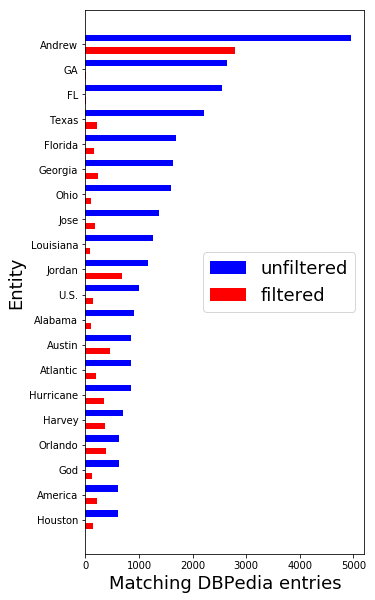

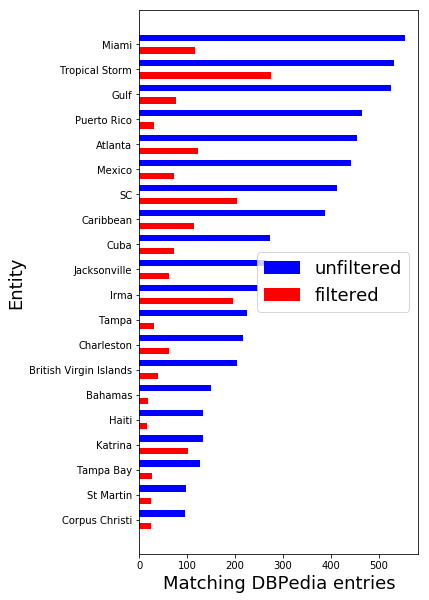

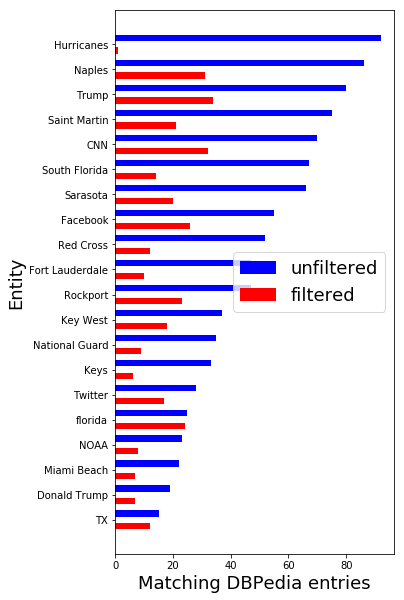

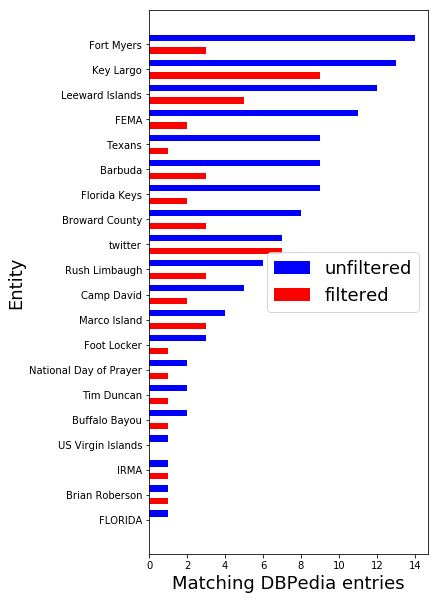

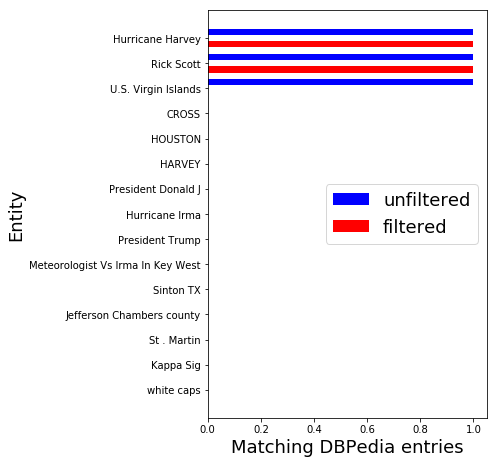

In [226]:
# plot entity counts for top-100 entities in descending order
top_k = 20
top_k_total = 100
series_names = ['unfiltered', 'filtered']
x_label = 'Matching DBPedia entries'
y_label = 'Entity'
for i in range(int(top_k_total / top_k)):
    top_k_i = (i+1)*top_k
    top_k_entities = entity_result_counts.index[top_k*i:top_k_i].tolist()
    series_1 = entity_result_counts.loc[top_k_entities][::-1]
    series_2 = entity_counts_capped.loc[top_k_entities][::-1]
    series_list = [series_1, series_2]
    plot_paired_bar_plot(series_list, series_names, x_label, y_label)
    plt.show()

OK! The filtering cuts down most of the entities' ambiguity by half.

TODO: is there a more nuanced filtering technique that gets rid of everything but the most relevant pages?

## Filtering by entity type?

TODO:

Second big problem:

The entity lists (even the filtered ones) include a lot of irrelevant entities! I was originally just looking for cities but this returned a lot of other geographic entities.

- companys: `Manhattan Supply Company`
- neighborhoods: `Manhattan Chinatown`
- schools: `Manhattan Country School`
- counties: `Manhattan County`
- TV shows: `Manhattan Manhunt`

## Determine which entities are actually ambiguous

Let's look for some basic examples of tweets that include at least one ambiguous entity.

For each ambiguous entity, we find tweets that contain the entity by itself, i.e. not as a substring of a larger entity. 

- For the ambiguous entity **Andrew** we would count "This hurricane is as big as **Andrew**" but not "This hurricane is as big as **Hurricane Andrew**" because **Hurricane Andrew** may be a separate entity from **Andrew**.

In [282]:
from IPython.display import display, Markdown
import re
pd.np.random.seed(123)
top_k = 20
ambiguous_entity_sample = entity_counts_capped.sort_values(inplace=False, ascending=False).index.tolist()[:top_k]
print(entity_counts_capped.loc[ambiguous_entity_sample])
tweet_entity_txt_file = '../../data/mined_tweets/#Irma,#Harvey,#HurricaneIrma,#HurricaneHarvey_combined_data_txt_ner.tsv'
tweet_entity_txt = [l.strip().replace('\n', '') for l in open(tweet_entity_txt_file, 'r')]
tweet_entity_txt = list(set(tweet_entity_txt))
sample_size = 10
make_bold = lambda x: '**%s**'%(x)
for sample_entity in ambiguous_entity_sample:
    print('sampling tweets for entity %s (ambiguity count %d)'%(sample_entity, entity_counts_capped.loc[sample_entity]))
    sample_entity_tokens = sample_entity.split(' ')
    entity_str = []
    for i, t in enumerate(sample_entity_tokens):
        if(i == 0):
            prefix = 'B'
        else:
            prefix = 'I'
        entity_str.append('%s/%s-ENTITY'%(t, prefix))
    entity_str = ' '.join(entity_str)
    # add buffer: we accept an entity only if 
    # it's not a sub-set of another entity, i.e. 
    # (1) at the end of a tweet or (2) followed by a non-entity
    # or new entity
    entity_str = '%s(?= \w+/[OB])|%s$'%(entity_str, entity_str)
    entity_matcher = re.compile(entity_str)
    matching_tweets = filter(lambda x: len(entity_matcher.findall(x)) > 0, tweet_entity_txt)
    print('got %d matching tweets'%(len(matching_tweets)))
    if(len(matching_tweets) > sample_size):
        matching_tweets = pd.np.random.choice(matching_tweets, size=sample_size, replace=False)
#     print('\n'.join(matching_tweets))
    # highlight matching entities in bold
    # and return-line separated
    print(display(Markdown(''.join(map(lambda x: '\n- %s'%(x), 
                                 [entity_matcher.sub(make_bold(entity_matcher.findall(t)[0]), t) 
                                  for t in matching_tweets])))))

Andrew            2789
Jordan             691
Austin             456
Orlando            380
Harvey             376
Hurricane          349
Tropical Storm     276
Georgia            245
Texas              226
America            209
SC                 205
Irma               196
Atlantic           190
Jose               187
Florida            167
U.S.               151
Houston            138
Atlanta            123
God                117
Miami              117
dtype: int64
sampling tweets for entity Andrew (ambiguity count 2789)
got 126 matching tweets



- **Andrew/B-ENTITY** dropped/O a/O high/O of/O 13.8/O inches/O ;/O #HurricaneIrma/O predictions/O show/O over/O 20/O inches/O possible/O ./O http:///O trib/O ./O al/ilgiU4v/O
- RT/O @markmobility/O :/O Cat/O 5/O **Andrew/B-ENTITY** devastated/O Florida/B-ENTITY in/O 1992/O ./O @EricHolthaus/O says/O #Irma/O is/O &gt;/O 5x/O more/O powerful/O (/O photo/O compares/O them/O )/O https://t.…/O
- Comparación/O **Andrew/B-ENTITY** 1992/O vs/O Irma/B-ENTITY 2017/I-ENTITY #irma/O @nbc6/O pic.twitter.com/NuRHrvbtOd/O
- **Andrew/B-ENTITY** was/O a/O monster/O ;/O #Irma/O could/O blow/O it/O out/O of/O the/O water/O http:///O bit/O ./O ly/2vLINio/O
- Sobrevivientes/O del/O huracán/O **Andrew/B-ENTITY** en/O 1992/O se/O preparan/O para/O la/O llegada/O de/O #Irma/O #Noticias23/O @UniNoticias/O http:///O ow/O ./O ly/cKkH30f1FEJ/O
- "/O As/O Irma/B-ENTITY approaches/O nuclear/O plants/O in/O Florida/B-ENTITY ,/O lessons/O from/O **Andrew/B-ENTITY** resonate/O http:///O dlvr/O ./O it/PlssQ7/O #BizIT/O #Science/O #Energy/O #IRMA/O "/O
- |/O Sobrevivientes/O del/O huracán/O **Andrew/B-ENTITY** se/O preparan/O para/O la/O llegada/O de/O #Irma/O a/O Florida/B-ENTITY http:///O uni/O ./O vi/7NXG30f1Pbl/O pic.twitter.com/frFW5Akui5/O
- For/O an/O entire/O generation/O in/O S/O ./O FL/O #Hurricane/O **Andrew/B-ENTITY** was/O the/O MonsterStorm/O that/O reshaped/O a/O region/O #Irma/O is/O likely/O to/O blow/O that/O out/O of/O the/O water/O pic.twitter.com/c1FJkhUtTJ/O
- RT/O @eloycam2012/O :/O Potencial/O destructivo/O 3/O veces/O mayor/O al/O de/O #Harvey/O 5/O veces/O el/O de/O **Andrew/B-ENTITY** 1992/O ;/O se/O enfila/O a/O Florida/B-ENTITY #Irma/O con/O energía/O d…/O
- RT/O @THE_CURE_4_U/O :/O #HurricaneIrma/O It/O is/O announced/O :/O #Harvey/O was/O a/O category/O 4/O and/O #Katrina/B-ENTITY and/O **Andrew/B-ENTITY** were/O a/O category/O 5/O ./O Irma/B-ENTITY now/O is/O st…/O

None
sampling tweets for entity Jordan (ambiguity count 691)
got 1 matching tweets



- @jordanwinery/O please/O send/O a/O fellow/O **Jordan/B-ENTITY** some/O cab/O to/O get/O through/O this/O storm/O #HurricaneHarvey/O #wineplease/O 🍷🌀/O

None
sampling tweets for entity Austin (ambiguity count 456)
got 57 matching tweets



- Austinite/O trapped/O in/O St/B-ENTITY ./O Thomas/B-ENTITY post/I-ENTITY Hurricane/I-ENTITY #Irma/O https:///O youtu/O ./O be/i5aT1oW-ohw/O via/O kxan/O **Austin/B-ENTITY**
- RT/O @abc13houston/O :/O ./O @POTUS/O and/O @FLOTUS/O will/O tour/O Corpus/B-ENTITY Christi/I-ENTITY and/O **Austin/B-ENTITY** in/O wake/O of/O #Harvey/O :/O https://t.co/DZ8Feywkpu/O
- RT/O @statesman/O :/O WEATHER/O UPDATE/O :/O Next/O band/O of/O heavy/O rainfall/O in/O **Austin/B-ENTITY** expected/O around/O 10/O a.m./O https://t.co/6NsxsyRtYs/O #atxweather/O #Harvey/O
- RT/O @statesman/O :/O WEATHER/O UPDATE/O :/O **Austin/B-ENTITY** could/O see/O 15/O inches/O of/O rain/O through/O Wednesday/O https://t.co/TL1IqYKvCl/O #HurricaneHarvey…/O
- RT/O @statesman/O :/O **Austin/B-ENTITY** Pets/O Alive/O seeks/O foster/O families/O after/O #HurricaneHarvey/O evacuee/O pets/O arrive/O https://t.co/aVehWt8L2F/O https://t.co/hcyk…/O
- RT/O @AustinHSEM/O :/O Public/O hurricane/O shelter/O information/O in/O **Austin/B-ENTITY** is/O available/O by/O calling/O 3-1-1/O or/O 512-974-2000/O ./O #Harvey/O
- RT/O @overatx/O :/O **Austin/B-ENTITY** makes/O the/O most/O of/O #HarveyStorm/O this/O afternoon/O in/O #ZilkerPark/O 's/O newly/O formed/O #ZilkerLake/O #atxweather/O https://t.co/we5MbI…/O
- "/O RT/O @statesman/O :/O Rains/O from/O #Harvey/O enter/O **Austin/B-ENTITY** schools/O ,/O displacing/O students/O https://t.co/o2KGJiueSf/O https://t.co/NMtBPB2nny/O "/O
- "/O RT/O @EaterAustin/O :/O **Austin/B-ENTITY** restaurants/O are/O raising/O money/O and/O collecting/O donations/O for/O #HurricaneHarvey/O relief/O ,/O updated/O https://t.co/l83BLnkP9y/O "/O
- "/O RT/O @statesman/O :/O **Austin/B-ENTITY** readies/O for/O thousands/O more/O #Harvey/O evacuees/O ,/O some/O stuck/O on/O roadshttps/O ://O /t/O ./O co/Peax57MPHh/O https://t.co/SRwNPaFSpf/O "/O

None
sampling tweets for entity Orlando (ambiguity count 380)
got 326 matching tweets



- "/O Everyone/O stay/O safe/O during/O #Irma/O ./O We/O hope/O to/O see/O you/O this/O coming/O Friday/O ,/O #**Orlando/B-ENTITY** at/O The/B-ENTITY Social/I-ENTITY 09/15/I-ENTITY ./O pic.twitter.com/dOut2kA1PO/O "/O
- Some/O I/O know/O left/O their/O homes/O in/O Broward/B-ENTITY for/O Tampa/B-ENTITY and/O **Orlando/B-ENTITY** to/O get/O away/O from/O #HurricaneIrma/O Well/O !!!!/O
- #Irma/O Posto/O do/O 7/O Eleven/O em/O **Orlando/B-ENTITY** distribui/O água/O de/O graça/O para/O moradores/O ./O O/O governador/O Rick/B-ENTITY Scott/I-ENTITY orientou/O aos/O .../O http:///O fb/O ./O me/2J9OxD7kr/O
- Esta/O chica/O mala/O podria/O llegar/O a/O Tampa/B-ENTITY y/O cruzar/O por/O **Orlando/B-ENTITY** en/O su/O salida/O por/O Jacksonville/B-ENTITY ?/O #Irma/O @adamonzon/O @JohnMoralesNBC6/O
- RT/O @exoticgamora/O :/O #hurricaneimra#IrmaHurricane2017/O Irma/B-ENTITY has/O made/O an/O appearance/O in/O **Orlando/B-ENTITY** and/O she/O is/O pretty/O terrifying/O ./O This/O is/O just/O th…/O
- "/O RT/O @nine_oh/O :/O 2,000/O alligators/O in/O **Orlando/B-ENTITY** will/O weather/O #HurricaneIrma/O ./O https://t.co/yoY78fvGER/O "/O
- "/O La/O policía/O de/O **Orlando/B-ENTITY** advierte/O sobre/O el/O ""/O asombroso/O ""/O tamaño/O de/O #Irma/O ./O http:///O uni/O ./O vi/45WG100MSI4/O https:///O twitter.com/OrlandoPolice//O status/906314898770202630/O …/O "/O
- The/O Islamic/O Center/O of/O **Orlando/B-ENTITY** will/O open/O to/O anyone/O seeking/O shelter/O during/O Hurricane/B-ENTITY #Irma/O Please/O see/O the/O info/O ./O posted/O :/O pic.twitter.com/3Ub6c5Gk75/O
- Evacuating/O to/O **Orlando/B-ENTITY** seemed/O like/O a/O good/O idea/O Thursday/O ./O We/O shall/O see/O ./O Will/O be/O riding/O out/O Irma/B-ENTITY at/O Disney/B-ENTITY 's/O art/O of/O animation/O resort/O ./O #Irma/O
- "/O Outlet/O de/O **Orlando/B-ENTITY** tem/O lojas/O fechadas/O antes/O da/O chegada/O do/O furacão/O Irma/B-ENTITY ,/O mostra/O apresentadora/O de/O TV/O do/O ES/O https:///O glo/O ./O bo/2gTKvvv/O #Irma/O #G1/O pic.twitter.com/f6chPFTFtU/O "/O

None
sampling tweets for entity Harvey (ambiguity count 376)
got 1007 matching tweets



- "/O RT/O @EcoInternet3/O :/O “We/O should/O be/O naming/O #hurricanes/O after/O Exxon/B-ENTITY and/O Chevron/B-ENTITY ,/O not/O **Harvey/B-ENTITY** and/O #Irma/O ./O ”/O :/O The/O New/O Republic/O https://t.co/SfeUEE7Si…/O "/O
- RT/O @12NewsNow/O :/O **Harvey/B-ENTITY** victims/O can/O apply/O for/O short-term/O food/O assistance/O starting/O Wednesday/O #12NewsNowHarvey/O #Harvey/O #409Strong…/O
- **Harvey/B-ENTITY** is/O almost/O here/O ./O Please/O be/O safe/O and/O stay/O home/O ./O We'll/O be/O posting/O STEM/O activities/O and/O videos/O throughout/O the/O weekend/O ./O #Harvey2017/O
- "/O RT/O @PaulFox13/O :/O **Harvey/B-ENTITY** like/O rain/O across/O central/O #Florida/O right/O now/O ./O The/O difference/O is/O ,/O Harvey/B-ENTITY 's/O rain/O lasted/O for/O days/O ,/O #Irma/O 's/O rain…/O "/O
- #localssupportlocals/O don't/O forget/O about/O the/O **Harvey/B-ENTITY** support/O that/O is/O going/O on/O all/O around/O !/O Support/O fellow/O Texans/O !/O #hurricaneharvey/O #support/O
- "/O My/O tribute/O to/O all/O the/O **Harvey/B-ENTITY** victims/O and/O survivors/O ,/O myself/O included/O ./O #Texasstrong/O #Houstonstrong/O #Harvey…/O https://t.co/qx20Xj92CY/O "/O
- Hurricane/O **Harvey/B-ENTITY** Brings/O Out/O The/O Best/O In/O Humanity/O -/O Grind/O 147/O https://t.co/XR0y1YWKB5/O #HarveyRelief/O #HarveyRecovery/O https://t.co/2RGTozPizq/O
- "/O #Trump/O signs/O $15/O billion/O #HurricaneHarvey/O **Harvey/B-ENTITY** relief/O ,/O debt/O ceiling/O package/O via/O the/O @FoxNews/O app/O http://www/O ./O foxnews.com/politics/2017//O 09/08/trump-signs-15-billion-harvey-relief-debt-ceiling-package/O ./O html/O …/O "/O
- “Trump/O signs/O $15/O billion/O **Harvey/B-ENTITY** aid/O bill/O into/O law”/O https:///O twitter.com/i/moments/9062/O 74086468198400/O …/O #Harvey2017/O #Harvey/O #Aid/O #Trump/O #news/O
- Please/O Support/O @Lumpy3166/O Help/O my/O Family/O after/O **Harvey/B-ENTITY** Won/O #HurricaneHarvey/O #Flood/O Donate/O Here/O -/O http:///O bit/O ./O ly/2wD4L8M/O pic.twitter.com/sKIYgxgUXb/O

None
sampling tweets for entity Hurricane (ambiguity count 349)
got 125 matching tweets



- #Irma/O is/O the/O **Hurricane/B-ENTITY** that/O just/O doesn't/O want/O to/O die/O or/O even/O weaken/O -/O it/O has/O been/O amazing/O to/O watch/O from/O a/O meteorological/O standpoint/O ./O
- **Hurricane/B-ENTITY** prep/O myths/O #HurricaneIrma/O http://www/O ./O tampabay.com/news/publicsaf/O ety/hurricane-irma-5-myths-about-hurricane-prep-to-forget/2336675/O …/O
- "/O **Hurricane/B-ENTITY** prep/O done/O ,/O hunkering/O down/O &/O playing/O with/O my/O nieces/O while/O waiting/O for/O Richmond/B-ENTITY race/O to/O start/O ./O Stay/O safe/O FL/O !/O #HurricaneIrma/O #NASCAR/O "/O
- **Hurricane/B-ENTITY** Is/O About/O To/O Be/O The/O Strongest/O To/O Slam/O Into/O The/O US/O In/O More/O Than/O A/O Decade/O -/O BuzzFeed/O News/O #HurricaneHarvey/O https://t.co/lCcWLrEqQd/O
- "/O **Hurricane/B-ENTITY** is/O coming/O ""../O Goes/O to/O the/O beach/O to/O try/O to/O take/O a/O cool/O pic*/O #hurricaneirma/O …/O https://www/O ./O instagram.com/p/BY1NhYdAosQ//O "/O
- TALLAHASSEE/B-ENTITY UPDATE/O :/O I/O have/O been/O actively/O preparing/O for/O **Hurricane/B-ENTITY** conditions/O ./O I/O will/O start/O more/O frequent/O updates/O this/O evening/O ./O #Irma/O
- 50%/O off/O admission/O for/O **Hurricane/B-ENTITY** evacuees/O at/O the/O #ashevillemuseumofscience/O #AMOS/O #hurricaneirma/O @…/O https://www/O ./O instagram.com/p/BY032Ltl9Qx//O
- LATEST/O :/O #Irma/O currently/O Cat/O ./O 3/O **Hurricane/B-ENTITY** with/O winds/O of/O 125/O mph/O ;/O expected/O to/O restrengthen/O as/O it/O heads/O towards/O Florida/B-ENTITY |/O @ABC/O
- The/O east/O side/O of/O the/O eye/O wall/O (/O right/O side/O when/O looking/O at/O **Hurricane/B-ENTITY** on/O the/O charts/O )/O is/O the/O wet/O side/O ./O It/O 's/O the/O rougher/O part/O #irma/O Good/O luck/O ./O
- #irma/O **Hurricane/B-ENTITY** winds/O https://www/O ./O pscp/O ./O tv/w/bIMbgjFvUEtM/O cFJYdk5LZG58MWpNS2dQT1BueWVHTMnx_WPkqRO3_Krlv0jMGgz9iN4C2mNZFBbI0lKQ6uBf/O …/O

None
sampling tweets for entity Tropical Storm (ambiguity count 276)
got 32 matching tweets



- "/O ATTN/O :/O Possible/O 4th/O Storm/O forming/O ./O If/O it/O does/O form/O into/O **Tropical/B-ENTITY Storm/I-ENTITY** it/O 's/O name/O will/O be/O ""/O Lee/B-ENTITY ""./O #Irma/O #Katia/O #Jose/O #HurricaneIrma/O #Hurricane/O ./O pic.twitter.com/5jSNcGehFz/O "/O
- RT/O @sasha_a_fox/O :/O This/O shows/O when/O you/O can/O expect/O **Tropical/B-ENTITY Storm/I-ENTITY** level/O winds/O to/O reach/O you/O from/O #TropicalStormIrma#HurricaneIrma…/O
- The/O most/O likely/O arrival/O time/O of/O **Tropical/B-ENTITY Storm/I-ENTITY** force/O winds/O will/O be/O sometime/O during/O the/O day/O Monday/O ./O That/O is/O winds/O >/O 39mph/O ./O #Irma/O pic.twitter.com/qbzH6TWedR/O
- RT/O @weathernetwork/O :/O **Tropical/B-ENTITY Storm/I-ENTITY** conditions/O are/O now/O being/O felt/O in/O the/O Florida/B-ENTITY Keys/I-ENTITY ./O #Irma/O has/O begun/O its/O northward/O turn/O toward/O Florida…/O
- "/O RT/O @Azizjneelam/O :/O #HurricaneIrma/O ,/O high/O probability/O of/O **Tropical/B-ENTITY Storm/I-ENTITY** Conditions/O throughout/O the/O entire/O Florida/B-ENTITY Peninsula/I-ENTITY ./O (Sep/O 9/O till/O S…/O "/O
- If/O #HurricaneIrma/O wasn't/O scary/O enough/O **Tropical/B-ENTITY Storm/I-ENTITY** Jose/O looks/O like/O it/O 's/O going/O to/O follow/O the/O same/O path/O https://t.co/7JBnIE2jlO/O
- RT/O @SDaviesNBC5/O :/O Our/O next/O **Tropical/B-ENTITY Storm/I-ENTITY** has/O formed/O ./O Tropical/B-ENTITY Storm/I-ENTITY Irma/I-ENTITY could/O be/O a/O Hurricane/O by/O Saturday/O ./O #Irma/O @nbcdfw/O https://t.co/GJI7U…/O
- #HurricaneIrma/O Max/O Wind/O Gusts/O :/O 125mph/O Strength/O :/O Cat/O 3/O MSLP/O :/O 933mb/O Uodate/O for/O **Tropical/B-ENTITY Storm/I-ENTITY** conditions/O occurring/O the/O Florida/B-ENTITY Keys/I-ENTITY .../O pic.twitter.com/jOAtNDoVRP/O
- #Hurricane/O Watches/O and/O **Tropical/B-ENTITY Storm/I-ENTITY** Watches/O have/O been/O expanded/O North/O into/O parts/O of/O #Georgia/O ./O #GAwx/O #FLwx/O #Irma/O pic.twitter.com/PFeAbefMeO/O
- "/O As/O we/O continue/O to/O watch/O #HurricaneIrma/O ,/O a/O reminder/O :/O Our/O hospitals/O lockdown/O when/O **Tropical/B-ENTITY Storm/I-ENTITY** winds/O are/O in/O area/O ./O http:///O martinhealth.org/irma/O "/O

None
sampling tweets for entity Georgia (ambiguity count 245)
got 321 matching tweets



- #irma/O #florida/O Just/O imagine/O if/O #**Georgia/B-ENTITY** and/O #Alabama/O built/O a/O wall/O
- Many/O **Georgia/B-ENTITY** schools/O have/O closed/O ahead/O of/O #HurricaneIrma/O --/O here/O is/O a/O list/O :/O http:///O 2wsb/O ./O tv/2gP8YPd/O #StormWatchOn2/O pic.twitter.com/juL7GOspHh/O
- "/O #Irma/O Pinoy/Pinay/FilAm/Filipinx/O sa/O Florida/**Georgia/B-ENTITY** at/O mga/O may/O kakilala/O ,/O subaybayan/O :/O emergency/O mgt/O accts/O sa/O @Twitter/O https:///O twitter.com/TwitterGov/lis/O ts/emergency-management/O …/O "/O
- Evacuated/O Florida/B-ENTITY ./O In/O **Georgia/B-ENTITY** now/O ./O Attempting/O to/O go/O to/O Indiana/B-ENTITY where/O family/O has/O a/O cabin/O ./O Scared/O of/O what/O #HurricaneIrma/O will/O bring/O ./O
- #Irma/O #USA/O ./O A/O friend/O of/O mine/O left/O Miami/B-ENTITY about/O 7/O pm/O on/O Thursday/O and/O reached/O her/O destination/O in/O **Georgia/B-ENTITY** after/O 10/O am/O .../O http:///O fb/O ./O me/8yyG4Xo62/O
- Cuba/B-ENTITY and/O **Georgia/B-ENTITY** too/O #irma/O pic.twitter.com/mtoi84T0NI/O
- 5pm/O #Irma/O update/O :/O Coastal/O **Georgia/B-ENTITY** and/O lower/O half/O of/O Coastal/B-ENTITY SC/I-ENTITY under/O a/O Tropical/O Storm/O Warning/O ./O http:///O ihe/O ./O art/Hyel2KO/O
- "/O Augusta/B-ENTITY University/I-ENTITY ,/O including/O the/O Dental/O College/O of/O **Georgia/B-ENTITY** and/O East/B-ENTITY Georgia/I-ENTITY State/I-ENTITY College/I-ENTITY Augusta/I-ENTITY ,/O will/O close/O Monday/O ,/O Sept/O ./O 11/O ./O #IrmaCSRA/O "/O
- RT/O RyanMaue/O :/O Winds/O in/O Atlanta/B-ENTITY and/O much/O of/O **Georgia/B-ENTITY** from/O Hurricane/B-ENTITY #Irma/O will/O be/O extreme/O for/O inland/O locations/O not/O used/O to/O such/O gusts/O pic.twitter.com/GVWyH1w3Fc/O
- More/O than/O 130/O KY/O electric/O co-op/O linemen/O are/O in/O **Georgia/B-ENTITY** helping/O with/O #Irma/O recovery/O (/O via/O @KentuckyLiving/O )/O #WeAreKY/O 💡…/O https://t.co/9kPkmwYM3Q/O

None
sampling tweets for entity Texas (ambiguity count 226)
got 1798 matching tweets



- RT/O @wes00181358/O :/O **Texas/B-ENTITY** Love/O !/O https://t.co/KgODhVbqJB#TexasStrong/O #Texas/O #TexasFlood/O #TexasForever/O #HurricaneHarvey/O #Flood…/O
- RT/O @iowa_trump/O :/O Good/O morning/O 🇺🇸❤️Praying/O for/O **Texas/B-ENTITY** and/O Louisiana/B-ENTITY #HarveyFlood/O #ThursdayThoughts/O #DayOfGiving#Houston/O https://t.co/TMm…/O
- FRIDAY/O NIGHT/O LIGHTS/O :/O West/O **Texas/B-ENTITY** rivals/O Abilene/B-ENTITY &/O Midland/B-ENTITY Lee/I-ENTITY come/O together/O to/O play/O Amazing/B-ENTITY Grace/I-ENTITY to/O honor/O #Houston/B-ENTITY #Harvey/O (/O via/O @BCHsports/O )/O pic.twitter.com/3H7rdZ9j2P/O
- RT/O @RoseAnnDeMoro/O :/O VA/O Nurse/O &amp;/O NNU/O leader/O in/O pic/O is/O in/O **Texas/B-ENTITY** volunteering/O through/O NNU/O helping/O #HurricaneHarvey/O ./O ❤️❤️/O https://t.co/11HuSBVKCw/O
- RT/O @AntonioArellano/O :/O **Texas/B-ENTITY** officials/O :/O Hurricane/O shelters/O won’t/O ask/O immigration/O status/O https://t.co/GXWDsTqdzX/O #HurricaneHarvey/O https://t.co…/O
- RT/O @TRConsulHouston/O :/O 🇹🇷/O Turks/O in/O **Texas/B-ENTITY** care/O 👏/O Turkish-Americans/O continue/O helping/O those/O who/O were/O affected/O by/O #Harvey/O 🙏/O https://t.co/rGiLYV2v…/O
- "/O #Harvey/O affected/O **Texas/B-ENTITY** areas/O :/O how/O did/O voting/O for/O climate/O change/O denying/O fools/O ,/O Rick/B-ENTITY Perry/I-ENTITY &amp;/O Greg/B-ENTITY Abbott/I-ENTITY ,/O work/O out/O ?/O https://t.co/tyIs7THfVF/O "/O
- RT/O @James_E_White/O :/O TX/B-ENTITY OAG/O warns/O **Texas/B-ENTITY** about/O #Harvey/O relief/O scams/O https://t.co/yhBGuGHAoJ/O
- "/O RT/O @PatrickSvitek/O :/O The/O White/B-ENTITY House/I-ENTITY says/O Trump/B-ENTITY will/O travel/O to/O **Texas/B-ENTITY** on/O Tuesday/O ,/O per/O pool/O ./O #Harvey/O https://t.co/OogJcCoKjT/O "/O
- PHOTOS/O :/O Let/O 's/O not/O forget/O #Harvey/O !!/O Our/O latest/O pics/O from/O **Texas/B-ENTITY** recovery/O ./O More/O in/O this/O album/O :/O https://www/O ./O facebook.com/CatholicNewsSe/O rvice/posts/10154687903275723/O …/O (/O CNS/Bob/O Roller/O )/O pic.twitter.com/HzhjuEbj5G/O

None
sampling tweets for entity America (ambiguity count 209)
got 212 matching tweets



- "/O Getting/O ready/O to/O take/O on/O #Irma/O head-on/O ./O If/O anything/O should/O happen/O to/O me/O ,/O all/O I/O ask/O is/O for/O **America/B-ENTITY** to/O support/O @realDonaldTrump/O to/O MAGA/B-ENTITY ."/O
- RT/O @USATOpinion/O :/O LOOK/O :/O #HurricaneHarvey/O shows/O **America/B-ENTITY** at/O its/O best/O ./O https://t.co/P48p0hK6eO/O https://t.co/L1TkKAkSnQ/O
- RT/O @JesusIsComing_2/O :/O #HurricaneHarvey/O **America/B-ENTITY** please/O listen/O to/O Him/O https://t.co/KPjlTkYzPk/O
- "/O RT/O @TrumpSuperPAC/O :/O TRUMP/B-ENTITY has/O already/O made/O **America/B-ENTITY** great/O again/O ,/O but/O will/O the/O lying/O traitors/O in/O mainstream/O media/O report/O it/O ?/O #HarveyHeroes/O htt…/O "/O
- **America/B-ENTITY** is/O pictured/O in/O #HoustonStrong/O ./O Caring/O for/O others/O despite/O ANY/O differences/O ./O #HurricaneHarveyRelief/O
- https://www/O ./O youtube.com/watch?v=YRxCy3/O r2CmQ&sns=tw/O …/O via/O @youtube/O ./O Senator/B-ENTITY Paul/I-ENTITY speech/O on/O urging/O colleagues/O to/O vote/O for/O **America/B-ENTITY** First/O #Harvey/O #Irma/O
- North/B-ENTITY Korea/I-ENTITY :/O We/O will/O kill/O you/O **America/B-ENTITY** with/O missles/O !/O Be/O afraid/O Irma/B-ENTITY :/O Hold/O my/O beer/O ./O Watch/O this/O shit/O ./O #HurricaneIrma/O
- RT/O @Vet_Report/O :/O This/O is/O what/O **America/B-ENTITY** looks/O like/O ./O If/O anyone/O deserves/O honor/O and/O respect/O it/O 's/O this/O man/O ./O RIP/O sir/O ./O #IGotYour6/O #Harvey…/O
- RT/O @HaikuVikingGal/O :/O #HurricaneHarvey/O is/O uniting/O citizens/O ./O A/O weather/O event/O is/O making/O **America/B-ENTITY** great/O again/O ./O Trump/B-ENTITY must/O be/O seething/O ./O
- Chasing/O a/O tropical/O storm/O back/O to/O **America/B-ENTITY** on/O a/O cruise/O ship/O sounds/O fun/O right/O ?/O #Harvey/O

None
sampling tweets for entity SC (ambiguity count 205)
got 120 matching tweets



- "/O #HurricaneIrma/O **SC/B-ENTITY** update/O :/O All/O NBSC/Synovus/O branches/O in/O Charleston/B-ENTITY will/O be/O closed/O thru/O Mon/O .,/O 9/11/O ./O https://www/O ./O synovus.com/hurricane-irma/O ?/O utm_source=twitter/O …/O "/O
- Guess/O I/O didn’t/O give/O an/O update/O recently/O .../O we/O are/O spending/O the/O night/O in/O **SC/B-ENTITY** thanks/O to/O a/O friend/O ./O Feeling/O grateful/O ./O #irma/O
- **SC/B-ENTITY** leaders/O were/O noticeably/O relieved/O at/O a/O press/O conference/O Saturday/O http://www/O ./O thestate.com/news/politics-/O government/article172278227/O ./O html/O …/O #thestate/O #sctweets/O #irma/O
- Another/O friend/O from/O TN/B-ENTITY was/O gonna/O take/O a/O trip/O to/O **SC/B-ENTITY** but/O she/O canceled/O because/O of/O #Irma/O ./O But/O now/O it/O seems/O like/O she/O should've/O taken/O the/O trip/O .../O
- Things/O are/O slightly/O looking/O better/O for/O **SC/B-ENTITY** throughout/O today/O with/O #irma/O track/O shifting/O West/O ./O Still/O impacts/O need/O to/O be/O ironed/O out/O ./O #scwx/O
- "/O Our/O thoughts/O and/O prayers/O go/O out/O to/O our/O friends/O and/O family/O in/O Florida/B-ENTITY ./O Myrtle/B-ENTITY Beach/I-ENTITY ,/O **SC/B-ENTITY** is/O a/O safe/O haven/O ./O #hurricaneirma/O #allarewelcome/O pic.twitter.com/UqJinroUM3/O "/O
- **SC/B-ENTITY** Alerts/O #scwx/O #Irma/O Charleston/B-ENTITY County/I-ENTITY :/O Trop/O Storm/O Watch/O Beaufort/B-ENTITY Colleton/I-ENTITY Jasper/I-ENTITY :/O Hurricane/O Watch/O https:///O twitter.com/track_irma/sta/O tus/906568171792080897/O …/O
- "/O States/O of/O emergency/O in/O Florida/B-ENTITY ,/O Georgia/B-ENTITY ,/O **SC/B-ENTITY** as/O Hurricane/B-ENTITY Irma/I-ENTITY lashes/O Puerto/B-ENTITY Rico/I-ENTITY #HurricaneIrma/O #Florida…/O https://t.co/xaAVOALPgz/O "/O
- RT/O @LindsayRileyWx/O :/O Models/O keeping/O #Irma/O just/O of/O east/O coast/O of/O FL/B-ENTITY ./O FL/B-ENTITY will/O still/O see/O hurricane/O force/O winds/O Sunday/O ./O GA/O &amp;/O **SC/B-ENTITY** on/O alert/O !/O https/O :/O …/O
- One/O of/O our/O trees/O in/O the/O backyard/O is/O bent/O as/O hell/O ./O The/O fact/O that/O we/O are/O inland/O in/O **SC/B-ENTITY** shows/O how/O much/O damage/O can/O happen/O #HurricaneIrma/O

None
sampling tweets for entity Irma (ambiguity count 196)
got 2795 matching tweets



- Hurricanes/B-ENTITY Harvey/I-ENTITY and/O **Irma/B-ENTITY** demand/O a/O Dutch/O approach/O http://www/O ./O amsterdam-water-science/O ./O nl/shared-content/O /news/news/2017/09/hurricanes-harvey-and-irma-ask-for-a-dutch-approach/O ./O html/O …/O #irma/O #harvey/O @VU_Science/O @Nieuwsuur/O
- "/O RT/O @Prime_Politics/O :/O NEW/O :/O Hurricane/O **Irma/B-ENTITY** Now/O a/O Category/O 3/O Storm/O ,/O According/O to/O National/B-ENTITY Hurricane/I-ENTITY Center/I-ENTITY #HurricaneIrma/O #Irma/O https://t.co/…/O "/O
- Hold/O up/O !/O **Irma/B-ENTITY** spelled/O backwards/O is/O Amri/O ./O It/O 's/O all/O coming/O together/O ./O #Mindblown/O #HurricaneIrma/O #ClimateChangeIsReal/O #StayWOKE/O @AmriiirmA/O
- #HurricaneIrma/O #FortLauderdale/O beginning/O to/O feel/O tropical/O storm/O winds/O &/O **Irma/B-ENTITY** still/O by/O Cuba/B-ENTITY ./O https:///O youtu/O ./O be/evNA-XrxTjU/O
- #HurricaneIrma/O on/O track/O to/O beat/O Hurricane/B-ENTITY Allen/I-ENTITY for/O strongest/O hurricane/O in/O the/O Atlantic/B-ENTITY ./O **Irma/B-ENTITY** is/O at/O 185/O mph/O ./O Allen/B-ENTITY was/O at/O 190/O mph/O #mcj2039/5/O
- "/O Impressive/O !/O ""/O This/O Delta/B-ENTITY flight/O raced/O **Irma/B-ENTITY** and/O won/O ""/O https://t.co/eIGgmpUoBh/O #Aviation/O #Irma/O #goosebumps/O "/O
- "/O Before/O **Irma/B-ENTITY** hits/O ,/O we're/O hitting/O up/O Epcot/O !/O #hurricaneirma/O #irma/O #epcot/O #epcotfoodandwine/O …/O https://www/O ./O instagram.com/p/BY1KLOqhZmq//O "/O
- Video/O :/O El/O huracán/O **Irma/B-ENTITY** recupera/O la/O categoría/O 5/O tras/O llegar/O a/O Cuba/B-ENTITY http:///O bit/O ./O ly/2xW2YvP/O #Irma/O
- Here/O 's/O to/O hoping/O Jose/B-ENTITY won't/O suddenly/O change/O his/O mind/O and/O decided/O to/O run/O after/O **Irma/B-ENTITY** again/O .../O #HurricaneJose/O #HurricaneIrma/O
- RT/O @ChrisSuchanKCTV/O :/O 2/O major/O hurricanes/O ./O **Irma/B-ENTITY** 160mph/O winds/O &amp;/O Jose/B-ENTITY 120mph/O winds/O ./O #IrmaHurricane2017/O #Irma/O #Jose/O #flwx/O https://t.co/OVRTWfqI5u/O

None
sampling tweets for entity Atlantic (ambiguity count 190)
got 119 matching tweets



- RT/O @FOX46News/O :/O BREAKING/O :/O #TropicalStormjose/O has/O formed/O in/O the/O **Atlantic/B-ENTITY** behind/O now/O Category/O 5/O #HurricaneIrma/O ./O DETAILS/O :/O …/O
- RT/O @ClimateSignals/O :/O Multiple/O ways/O #climatechange/O amplifies/O damage/O done/O by/O #Irma/O -/O a/O full/O science/O run-down/O for/O **Atlantic/B-ENTITY** hurricanes/O here/O :/O …/O
- "/O Some/O of/O the/O warmest/O temperatures/O in/O the/O **Atlantic/B-ENTITY** sit/O between/O Cuba/B-ENTITY and/O Florida/B-ENTITY ,/O hovering/O ~85°/O #HurricaneIrma/O likely/O to/O strengthen/O pic.twitter.com/8eT71PtPmX/O "/O
- RT/O @philklotzbach/O :/O 2/O **Atlantic/B-ENTITY** hurricanes/O currently/O have/O winds/O of/O 150/O mph/O (#Irma/O and/O #Jose/O )/O -/O 1st/O time/O on/O record/O **Atlantic/B-ENTITY** has/O had/O 2/O 150…/O
- RT/O NASA/O :/O RT/O NASA_SPoRT/O :/O The/O horizontal/O extent/O of/O this/O storm/O is/O staggering/O ./O Latest/O from/O NHC_**Atlantic/B-ENTITY** has/O #Irma/O mov…/O https:///O twitter.com/i/web/status/9/O 06307679882276864/O …/O
- RT/O @POLITICO_Steve/O :/O More/O bad/O news/O :/O We/O now/O have/O Tropical/B-ENTITY Storm/I-ENTITY #Jose/O in/O the/O **Atlantic/B-ENTITY** behind/O #Irma/O ./O Expected/O to/O become/O a/O hurricane/O in/O 36-…/O
- RT/O @rahmstorf/O :/O Three/O **Atlantic/B-ENTITY** hurricanes/O at/O once/O now/O !/O #Irma/O #Jose/O #Katia/O https://t.co/77OgOqxglF/O
- "/O RT/O @ReedTimmerAccu/O :/O Major/O storm/O surge/O over/O pier/O on/O **Atlantic/B-ENTITY** side/O of/O Key/B-ENTITY West/I-ENTITY ,/O FL/B-ENTITY ahead/O of/O Hurricane/O #Irma/O @breakingweather/O https://t.co/Doq…/O "/O
- "/O RT/O @ReedTimmerAccu/O Major/O storm/O surge/O over/O pier/O ,/O **Atlantic/B-ENTITY** side/O of/O Key/B-ENTITY West/I-ENTITY ,/O ahead/O of/O Hurricane/B-ENTITY #Irma/O @breakingweather/O pic.twitter.com/FfvKn1O5GI/O "/O
- RT/O NASA_SPoRT/O :/O The/O horizontal/O extent/O of/O this/O storm/O is/O staggering/O ./O Latest/O from/O NHC_**Atlantic/B-ENTITY** has/O #Irma/O moving/O W12/O MP…/O https:///O twitter.com/i/web/status/9/O 06307679882276864/O …/O

None
sampling tweets for entity Jose (ambiguity count 187)
got 121 matching tweets



- **Jose/B-ENTITY** bianco/O mostrando/O la/O previa/O de/O #Irma/O me/O esta/O haciendo/O el/O sábado/O
- "/O In/O case/O you/O missed/O it/O :/O #HurricaneIrma/O and/O her/O siblings/O ,/O **Jose/B-ENTITY** and/O Katia/O ./O #GetOut/O pic.twitter.com/AL2r2xxJC8/O "/O
- "/O Prayers/O go/O out/O to/O everyone/O effected/O by/O hurricane/O Harvey/B-ENTITY ,/O Irma/B-ENTITY ,/O **Jose/B-ENTITY** and/O Katia/B-ENTITY #HurricaneIrma/O #Staysafe/O "/O
- I/O hope/O Irma/B-ENTITY and/O **Jose/B-ENTITY** are/O enough/O to/O make/O climate/O change/O FACT/O and/O not/O political/O #trump/O #russia/O #china/O #Irma/O #Florida/O
- "/O RT/O @MJVentrice/O :/O For/O the/O first/O time/O in/O their/O existance/O ,/O Major/B-ENTITY Hurricane/I-ENTITY #Jose/O is/O stronger/O than/O Major/B-ENTITY Hurricane/I-ENTITY #Irma/O ./O **Jose/B-ENTITY** at/O 145mph…/O "/O
- "/O Increase/B-ENTITY category/O 4/O +/O 5/O #hurricanes/O due/O to/O #climatechange/O After/O #Harvey/O and/O strongest/O #Irma/O ,/O #**Jose/B-ENTITY** is/O next/O ./O https://www/O ./O theguardian.com/world/2017/sep/O /09/hurricane-jose-storm-almost-category-five-as-it-follows-irmas-destructive-path/O …/O "/O
- Let/O 's/O name/O the/O next/O hurricane/O **Jose/B-ENTITY** so/O Trump/B-ENTITY will/O actually/O do/O something/O about/O it/O and/O not/O cut/O funds/O from/O #FEMA/O #HurricaneIrma/O #fucktrump/O
- "/O Meanwhile/O as/O #Hurricane/O #Irma/O and/O #Jose/O begin/O to/O make/O landfall/O on/O American/B-ENTITY soil/O ,/O @realDonaldTrump/O &/O supporters/O just/O want/O **Jose/B-ENTITY** deported/O ."/O
- RT/O @AaronDiamantWSB/O :/O With/O all/O eyes/O on/O #Irma/O .../O this/O update/O on/O #**Jose/B-ENTITY** just/O minutes/O ago/O from/O @NHC_Atlantic/O 👇/O https://t.co/aybcwYk1Xs/O
- "/O La/O #Floride/O attend/O l'ouragan/O #Irma/O ,/O **Jose/B-ENTITY** menace/O les/O Antilles/O http:///O owl/O ./O li/Ejtz30f1GkV/O "/O

None
sampling tweets for entity Florida (ambiguity count 167)
got 6597 matching tweets



- @Schafernaker/O hey/O just/O saw/O my/O fave/O weatherman/O in/O **Florida/B-ENTITY** on/O #bbcnews/O Frightening/O times/O ./O Stay/O safe/O T/O #HurricaneIrma/O
- "/O Not/O a/O meteorologist/O but/O given/O the/O trend/O ,/O can/O see/O the/O core/O of/O #Irma/O totally/O missing/O the/O **Florida/B-ENTITY** peninsula/O ."/O
- "/O RT/O @POWER104FM/O :/O **Florida/B-ENTITY** residents/O attempt/O to/O flee/O #HurricaneIrma/O ,/O the/O state/O is/O experiencing/O massive/O traffic/O jams/O “All/O Floridians/O be…/O "/O
- **Florida/B-ENTITY** erwartet/O #Irma/O ./O Mittendrin/O die/O Schweizerin/O Maria/B-ENTITY von/O Atzigen/O ./O https://www/O ./O tagesanzeiger/O ./O ch/news/standard//O Ich-weiss-dass-der-Wind-mein-Auto-wegtragen-koennte/story/29813268/O ?/O utm_source=twitter&utm_campaign=Ed_Social_Post&utm_medium=Ed_Post_TA/O …/O
- "/O The/O people/O who/O are/O staying/O in/O **Florida/B-ENTITY** are/O breaking/O my/O heart/O ./O No/O ,/O this/O NOT/O just/O another/O storm/O ./O #HurricaneIrma/O "/O
- Governador/O da/O **Florida/B-ENTITY** dizendo/O que/O quando/O a/O tempestade/O chegar/O ninguém/O estará/O a/O salvo/O e/O que/O não/O haverá/O forças/O da/O lei/O para/O ajudar/O .../O #irma/O
- "/O RT/O @ABC/O :/O Currently/O ,/O there/O are/O more/O than/O 200,000/O people/O in/O **Florida/B-ENTITY** without/O power/O due/O to/O Hurricane/O #Irma/O ./O https://t.co/0MAQ45jzlG/O "/O
- MUCH/O less/O air/O traffic/O over/O the/O state/O of/O **Florida/B-ENTITY** as/O the/O first/O outer/O band/O of/O #HurricaneIrma/O approaches/O #Miami/O &/O FL/B-ENTITY Keys/I-ENTITY with/O 40-45/O gusts/O ./O pic.twitter.com/N3OgVNCsSb/O
- "/O RT/O @ABC/O :/O Eerie/O scene/O in/O Key/B-ENTITY Largo/I-ENTITY ,/O **Florida/B-ENTITY** as/O ocean/O recedes/O amid/O Hurricane/O #Irma/O ,/O leaving/O boat/O sitting/O on/O dry/O land…/O "/O
- RT/O @hurrtrackerapp/O :/O The/O updated/O cone/O now/O takes/O Hurricane/O #Irma/O through/O **Florida/B-ENTITY** and/O into/O parts/O of/O Georgia/B-ENTITY and/O South/B-ENTITY Carolina/I-ENTITY ./O https://t.co/o…/O

None
sampling tweets for entity U.S. (ambiguity count 151)
got 133 matching tweets



- NHC/O has/O begun/O issuing/O hourly/O updates/O on/O Hurricane/B-ENTITY #Irma/O ./O These/O will/O continue/O until/O the/O eye/O is/O no/O longer/O visible/O on/O **U.S./B-ENTITY** Doppler/O Radar/O ./O –/O bei/O Joint/B-ENTITY Base/I-ENTITY Pearl/I-ENTITY Harbor-Hickam/I-ENTITY
- RT/O @NASAGoddardPix/O :/O #HurricaneHarvey/O could/O be/O the/O strongest/O to/O hit/O the/O **U.S./B-ENTITY** in/O more/O than/O a/O decade/O when/O it/O reaches/O the/O Texas/B-ENTITY coast/O Frida…/O
- RT/O @StateDept/O :/O Local/O numbers/O for/O emergency/O services/O and/O info/O for/O **U.S./B-ENTITY** citizens/O in/O areas/O affected/O by/O #HurricaneIrma/O overseas/O :/O …/O
- 5.6/O mil/O Americans/O have/O been/O told/O to/O flee/O #Irma/O ./O This/O is/O by/O far/O the/O largest/O mass/O movement/O of/O people/O in/O **U.S./B-ENTITY** history/O ./O #climatechangerefugees/O
- "/O RT/O @DeptofDefense/O :/O First/O responders/O ,/O #military/O ,/O and/O federal/O agencies/O from/O across/O the/O **U.S./B-ENTITY** assist/O #Harvey/O victims/O ./O See/O the/O impact/O here/O :/O …/O "/O
- RT/O @weatherchannel/O :/O Why/O the/O Hurricane/O #Irma/O Forecast/O for/O the/O **U.S./B-ENTITY** Is/O Still/O Uncertain/O and/O Difficult/O :/O https://t.co/YP6ZlfMfSX/O https://t.co/bW…/O
- "/O RT/O @VSPVisionCare/O :/O **U.S./B-ENTITY** Disaster/O Outreach/O :/O If/O you/O lost/O or/O broke/O your/O glasses/O due/O to/O #HurricaneHarvey/O or/O #HurricaneIrma/O ,/O we/O can/O help/O ./O …/O "/O
- RT/O @philklotzbach/O :/O #Irma/O has/O made/O landfall/O in/O FL/B-ENTITY Keys/I-ENTITY as/O a/O Cat/O ./O 4/O -/O 1st/O year/O on/O record/O that/O **U.S./B-ENTITY** has/O had/O 2/O Cat/O ./O 4+/O #hurricane/O landfall…/O
- Retweeted/O ABC/B-ENTITY News/I-ENTITY (/O @ABC/O )/O :/O We’re/O tracking/O Hurricane/O #Irma/O as/O it/O makes/O its/O way/O toward/O the/O **U.S./B-ENTITY** Live/O radar/O :.../O http:///O fb/O ./O me/zzN6Sa6x/O
- RT/O @StateDept/O :/O Local/O numbers/O for/O emergency/O services/O and/O information/O for/O **U.S./B-ENTITY** citizens/O abroad/O in/O areas/O affected/O by/O #HurricaneIrma/O :/O …/O

None
sampling tweets for entity Houston (ambiguity count 138)
got 1447 matching tweets



- RT/O @MikeHudema/O :/O 19/O TRILLION/O GALLONS/O of/O water/O fell/O on/O **Houston/B-ENTITY** during/O #HurricaneHarvey/O ./O That/O 's/O not/O normal/O ./O https://t.co/f33lVUuatw…/O
- RT/O @AaronWBIR/O :/O Standing/O by/O at/O Dallas/B-ENTITY Love/I-ENTITY Field/I-ENTITY for/O the/O first/O flights/O from/O Hobby/B-ENTITY airport/O in/O **Houston/B-ENTITY** to/O Dallas/B-ENTITY since/O #Harvey/O ./O …/O
- RT/O @ChronFalkenberg/O :/O Why/O didn't/O **Houston/B-ENTITY** evacuate/O for/O #Harvey/O ?/O Let/O me/O break/O it/O down/O :/O EPIC/O TRAFFIC/O +/O EPIC/O FLOODING/O =/O EPIC/O DEATH…/O
- "/O RT/O @life0ff/O :/O SOS/B-ENTITY !/O MANY/O people/O &amp;/O BABIES/O in/O need/O of/O rescue/O ASAP/O !/O @/O Riviera/B-ENTITY Pine/I-ENTITY Apt/I-ENTITY .,/O 555/O NORMANDY/B-ENTITY STREET/I-ENTITY ,/O **Houston/B-ENTITY** 77015/O #HarveySOS/O @HarveyRe…/O "/O
- RT/O @carolynsave/O :/O The/O needs/O of/O kids/O in/O crisis/O are/O big/O ..../O we/O are/O still/O working/O with/O children/O in/O #**Houston/B-ENTITY** and/O now/O preparing/O for/O #Irma/O https://…/O
- #crybully/O @CNNValencia/O making/O the/O #Harvey/O story/O about/O him/O ./O We/O are/O under/O water/O in/O #**Houston/B-ENTITY** and/O precious/O gets…/O https://t.co/FLy0CvkgxE/O
- "/O RT/O @tmwinsett/O :/O @JoyAnnReid/O #Harvey/O If/O anyone/O needs/O water/O rescue/O in/O #**Houston/B-ENTITY** area/O ,/O shld/O contact/O @USCG/O ./O Answered/O me/O quickly/O when/O tryi…/O "/O
- First/O they/O were/O in/O #**Houston/B-ENTITY** now/O #Florida/O ./O #LAFD/O going/O above/O and/O beyond/O the/O call/O of/O duty/O ./O #Irma/O #HurricaneIrma/O #IrmaRelief/O #IrmaRescue/O https:///O twitter.com/ABC/status/906/O 633788679086081/O …/O
- 1340/O Thanks/O @AmericanAir/O for/O a/O smooth/O ride/O on/O flight/O #TR1/O to/O #**Houston/B-ENTITY** for/O @TeamRubicon/O volunteers/O #Harvey/O pic.twitter.com/X1sdvcz1r8/O
- National/O Trust/O and/O preservationists/O stand/O ready/O to/O help/O **Houston/B-ENTITY** bounce/O back/O from/O #HurricaneHarvey/O https://t.co/7sKRQqUnWn/O via/O @savingplaces/O

None
sampling tweets for entity Atlanta (ambiguity count 123)
got 131 matching tweets



- RIGHT/O NOW/O @cbs46/O :/O @OssmannCBS46/O '/O s/O forecast/O and/O what/O metro/O **Atlanta/B-ENTITY** could/O see/O from/O #Irma/B-ENTITY ./O #cbs46Irma/O
- So/O does/O the/O current/O trajectory/O mean/O it/O will/O be/O raining/O pythons/O in/O **Atlanta/B-ENTITY** on/O Monday/O ?/O #Irma/O
- #Irma/O is/O expected/O to/O impact/O **Atlanta/B-ENTITY** on/O Monday/O morning/O w//O wind/O gusts/O up/O to/O 40-50/O mph/O &/O heavy/O rain/O ./O Here/O 's/O how/O to/O prepare/O :/O @ATLPreparedness/O pic.twitter.com/qgvjYXatmS/O
- RT/O @RyanMaue/O :/O &gt;/O 20-million/O would/O see/O hurricane/O force/O wind/O gusts/O (/O &gt;/O 74/O mph/O )/O from/O Hurricane/B-ENTITY #Irma/O from/O Keys/Miami/B-ENTITY to/O **Atlanta/B-ENTITY** on/O the…/O
- Made/O it/O to/O **Atlanta/B-ENTITY** from/O Jacksonville/B-ENTITY ./O Now/O it/O 's/O time/O to/O wait/O #Irma/O out/O and/O get/O back/O ASAP/O to/O access/O the/O damage/O ./O
- My/O family/O is/O off/O to/O **Atlanta/B-ENTITY** this/O morning/O ./O I'm/O staying/O behind/O along/O with/O the/O @ActionNewsJax/O crew/O to/O provide/O you/O nonstop/O #irma/O coverage/O pic.twitter.com/CHVhX0cvpr/O
- I/O was/O able/O to/O grab/O my/O friend/O and/O get/O out/O of/O FL/B-ENTITY ./O We/O made/O it/O to/O **Atlanta/B-ENTITY** and/O I/O want/O to/O go/O back/O to/O FL/B-ENTITY ./O JK/O !/O NYC/B-ENTITY here/O we/O come/O ./O #HurricaneIrma/O
- Several/O **Atlanta/B-ENTITY** businesses/O &/O sports/O teams/O are/O offering/O discounts/O to/O #Irma/O evacuees/O ./O Click/O here/O :/O http:///O bit/O ./O ly/2wRB8QW/O @AtlantaMagazine/O
- Amazing/O customer/O service/O @Delta/O -/O in/O just/O 15/O mins/O they/O changed/O my/O flight/O that/O was/O scheduled/O to/O depart/O through/O **Atlanta/B-ENTITY** early/O next/O week/O #Irma/O
- These/O folks/O in/O **Atlanta/B-ENTITY** are/O going/O bonkers/O behind/O #Irma/O

None
sampling tweets for entity God (ambiguity count 117)
got 484 matching tweets



- #IrmaHurricane2017/O ohh/O **God/B-ENTITY** give/O strength/O to/O pepole/O and/O be/O with/O them/O ../O #irma/O
- RT/O @TheRealSouljen/O :/O Praying/O that/O **God/B-ENTITY** calms/O the/O storm🙏/O #HurricaneHarvey/O #PrayforTexas/O #PrayForHouston/O #PrayForLouisiana/O #PrayForGulfCoast/O
- "/O I/O hope/O #Irma/O disposes/O of/O this/O idiot/O ./O gues/O she/O is/O going/O to/O blame/O **God/B-ENTITY** for/O the/O fires/O in/O California/B-ENTITY ""/O hope/O she/O burns/O in/O hell/O ""/O #JenniferLawerence/O https:///O twitter.com/prageru/status/O /906237330247131136/O …/O "/O
- "/O Job/O 36/O 21/O ./O Be/O on/O guard/O !/O Turn/O back/O from/O evil/O ,/O for/O **God/B-ENTITY** sent/O this/O suffering/O to/O keep/O you/O from/O a/O life/O of/O evil/O ./O #PrepareTheWay/O #HurricaneHarvey/O pic.twitter.com/rw3IP1qXBI/O "/O
- "/O https:///O youtu/O ./O be/p4rRCjrAyCs/O **God/B-ENTITY** put/O a/O hedge/O of/O protection/O over/O each/O &/O every/O person/O ,/O animals/O ,/O workplaces/O &/O homes/O in/O the/O path/O of/O #HurricaneIrma/O I/O "/O
- #HurricaneIrma/O Hallelujah/O humans/O are/O weak/O before/O the/O power/O of/O **God/B-ENTITY** storms/O and/O earthquakes/O and/O hurricanes/O all/O of/O the/O soldiers/O of/O God/O
- The/O **God/B-ENTITY** i/O know/O is/O so/O much/O bigger/O than/O #Irma/O .../O #Girlbye/O !/O
- "/O **God/B-ENTITY** has/O authority/O over/O #HurricaneIrma/O ,/O as/O well/O as/O all/O the/O storms/O we/O face/O in/O this/O broken/O world/O ./O Thank/O you/O @MaxLucado/O http://www/O ./O foxnews.com/opinion/2017/0/O 9/08/max-lucado-hurricane-irma-is-coming-where-is-god/O ./O html/O …/O "/O
- "/O RT/O @KingAbdullahll/O :/O @IvankaTrump/O Sincerely/O love/O you/O Ante/O ,/O and/O pray/O to/O **God/B-ENTITY** to/O protect/O people/O from/O typhoon/O ./O #HurricaneIrma#King/O ✨/O "/O
- RT/O @josmanhda/O :/O Be/O safe/O #Florida/O !/O **God/B-ENTITY** is/O with/O U#HurricaneIrma/O https://t.co/CvYDMAHmd5/O

None
sampling tweets for entity Miami (ambiguity count 117)
got 1786 matching tweets



- RT/O @WFLAJosh/O :/O Roof/O of/O a/O home/O in/O #**Miami/B-ENTITY** coast/O being/O ripped/O off/O by/O powerful/O #HurricaneIrma/O winds/O ./O Terrifying/O stuff/O ./O These/O winds/O are…/O
- Hurricane/O #Irma/O :/O Flamingos/B-ENTITY at/O **Miami/B-ENTITY** zoo/O moved/O to/O safety/O http://www/O ./O bbc.co.uk/news/world-us-/O canada-41212623/O …/O @BBCNews/O
- "/O **Miami/B-ENTITY** y/O Broward/B-ENTITY Atención/I-ENTITY :/O a/O pesar/O de/O q/O #Irma/O se/O ha/O movido/O un/O poco/O hacia/O el/O oeste/O de/O la/O FL/O ,/O aviso/O de/O huracán/O continúa/O para/O toda/O FL/O ./O Atentos/O pic.twitter.com/Y8Vzxt5HGI/O "/O
- "/O Now/O 10%/O chance/O wind/O losses/O from/O #Irma/O >$70B/O ./O ""/O Focus/O shifted/O from/O **Miami/B-ENTITY** to/O Tampa/B-ENTITY ""/O -/O @TSabbatelli_RMS/O via/O http:///O bit/O ./O ly/2vMHSya/O #RMSonIRMA/O pic.twitter.com/6Bvn3HlM07/O "/O
- SPECIAL/O LIVE/O coverage/O of/O #HurricaneIrma/O from/O our/O sister/O station/O in/O **Miami/B-ENTITY** available/O locally/O on/O KKSF/B-ENTITY 910/O now/O ./O http:///O ihe/O ./O art/BnBe0n5/O
- "/O #Irma/O still/O 225/O miles/O south/O of/O **Miami/B-ENTITY** and/O already/O 25,000/O people/O without/O power/O in/O Miami-Dade/B-ENTITY county/I-ENTITY ./O Winds/O gusting/O 50+/O mph/O ."/O
- RT/O @GMA/O :/O WATCH/O :/O **Miami/B-ENTITY** battered/O by/O Hurricane/O #Irma/O ;/O monster/O storm/O leaves/O parts/O of/O the/O city/O underwater/O :/O https://t.co/V37dSvjnW3/O https://t.co/…/O
- "/O RT/O MiamiWeatherNow/O ""/O It/O 's/O 83F/O in/O #**Miami/B-ENTITY** with/O rain/O in/O the/O area/O &amp;/O winds/O at/O E/O 21.92/O mph/O #Irma/O https://t.co/YdDi1Zm6Lr/O https://t.co/0ekFQLUA5o/O "/O
- #Irma/O empezando/O a/O cubrir/O **Miami/B-ENTITY** con/O sus/O aspas/O ./O #IrmaHurricane2017/O
- "/O #irma_infoQuébec/O #Irma/O :/O ville/O fantôme/O battue/O par/O les/O vents/O ,/O **Miami/B-ENTITY** attend/O l'ouragan./O pic.twitter.com/N4jCK17c6S/O "/O

None


At first glance, most of these tweets seem to refer to the most obvious entity.

Can we just count how many of these tweets contain an ambiguous entity? Is that allowed??

\* indicates that searching DBPedia for the original entity string redirects to the specified entity name (e.g., searching for "Orlando" redirects to "Orlando, FL").

**Andrew**:

- Hurricane ~: 10

**Austin**:

- ~, TX\*: 10

**Orlando**:

- ~, FL\*: 10

**Harvey**:

- Hurricane ~: 10

**Hurricane**:

- specific ~: 5
- generic ~: 5

**Tropical Storm**:

- part of name: 1 
- generic ~: 9

**Georgia**:

- state of ~\*: 9
- Dental College of ~: 1

**Texas**:

- state of ~\*: 9
- West ~ University: 1 

**America**:

- country of ~\*: 10

**SC**:

- South Carolina: 10

**Irma**:

- Hurricane ~: 9
- name: 1 

**Atlantic**:

- ~ Ocean\*: 10

**Jose**:

- Hurricane ~: 10

**Florida**:

- state of ~\*: 10

**U.S.**:

- country of ~\*: 10

**Houston**:

- city of ~\*: 10

**Atlanta**:

- city of ~\*: 10

**God**:

- ~\*: 10

**Miami**:

- city of ~\*: 10

On the whole it looks like most of the entity references in the tweets refer to the most common entity: the string "Miami" always refers to the city which is the page that a user is redirected to when querying DBPedia.

What if we use less common entities as the sample strings? This might trigger more ambiguity.

In [273]:
entity_count_median = entity_counts_capped.sort_values(inplace=False, ascending=False).median()
print(entity_counts_capped[entity_counts_capped < entity_count_median][:5])
print(entity_counts_capped[entity_counts_capped >= entity_count_median][-5:])

Haiti            16
GA               14
South Florida    14
Red Cross        12
TX               12
dtype: int64
FL          20
Sarasota    20
Bahamas     19
Key West    18
Twitter     17
dtype: int64


In [281]:
pd.np.random.seed(123)
top_k = 20
# let's get all entities around the middle
# N = int(len(entity_counts_capped) / 2)
# n = int(top_k/2)
entity_counts_capped.sort_values(inplace=True, ascending=False)
i = 1
# ambiguous_entity_sample = entity_counts_capped.index.tolist()[N-n:N+n]
# top 20 through 45 (to make up for Jordan error)
ambiguous_entity_sample = entity_counts_capped.index.tolist()[top_k * i:top_k * (i+1)+5]
print(entity_counts_capped.loc[ambiguous_entity_sample])
tweet_entity_txt_file = '../../data/mined_tweets/#Irma,#Harvey,#HurricaneIrma,#HurricaneHarvey_combined_data_txt_ner.tsv'
tweet_entity_txt = [l.strip().replace('\n', '') for l in open(tweet_entity_txt_file, 'r')]
tweet_entity_txt = list(set(tweet_entity_txt))
sample_size = 10
make_bold = lambda x: '**%s**'%(x)
for sample_entity in ambiguous_entity_sample:
    print('sampling tweets for entity %s (ambiguity count %d)'%(sample_entity, entity_counts_capped.loc[sample_entity]))
    sample_entity_tokens = sample_entity.split(' ')
    entity_str = []
    for i, t in enumerate(sample_entity_tokens):
        if(i == 0):
            prefix = 'B'
        else:
            prefix = 'I'
        entity_str.append('%s/%s-ENTITY'%(t, prefix))
    entity_str = ' '.join(entity_str)
    # add buffer: we accept an entity only if 
    # it's not a sub-set of another entity, i.e. 
    # (1) at the end of a tweet or (2) followed by a non-entity
    # or new entity
    entity_str = '%s(?= \w+/[OB])|%s$'%(entity_str, entity_str)
    entity_matcher = re.compile(entity_str)
    matching_tweets = filter(lambda x: len(entity_matcher.findall(x)) > 0, tweet_entity_txt)
    print('got %d matching tweets'%(len(matching_tweets)))
    if(len(matching_tweets) > sample_size):
        matching_tweets = pd.np.random.choice(matching_tweets, size=sample_size, replace=False)
#     print('\n'.join(matching_tweets))
    # highlight matching entities in bold
    # and return-line separated
    display(Markdown(''.join(map(lambda x: '\n- %s'%(x), 
                                 [entity_matcher.sub(make_bold(entity_matcher.findall(t)[0]), t) 
                                  for t in matching_tweets]))))

Caribbean                 115
Katrina                   102
Alabama                   101
Ohio                       97
Louisiana                  93
Gulf                       77
Mexico                     73
Cuba                       73
Charleston                 63
Jacksonville               62
British Virgin Islands     40
Trump                      34
CNN                        32
Puerto Rico                31
Tampa                      31
Naples                     31
Tampa Bay                  26
Facebook                   26
Corpus Christi             24
St Martin                  24
florida                    24
Rockport                   23
Saint Martin               21
FL                         20
Sarasota                   20
dtype: int64
sampling tweets for entity Caribbean (ambiguity count 115)
got 167 matching tweets



- "/O RT/O @CNN/O :/O **Caribbean/B-ENTITY** islands/O are/O accustomed/O to/O storm/O season/O ,/O but/O #HurricaneIrma/O has/O plenty/O of/O residents/O worried/O https://t.co/ZgwYTwS2fH/O #Irma/O "/O
- RT/O @casthompson/O :/O .../O Verizon/B-ENTITY customers/O connect/O with/O friends/O and/O family/O in/O the/O **Caribbean/B-ENTITY** for/O free/O #Irma/O #IamVZ/O https://t.co/RiRaSKCJGT/O https…/O
- @RoyalCaribbean/O &/O @CruiseNorwegian/O THANK/O YOU/O for/O sending/O ships/O to/O the/O **Caribbean/B-ENTITY** for/O relief/O and/O evacuation/O !!!/O #HurricaneIrma/O #USVI/O #VIStrong/O
- Cuba/B-ENTITY helping/O the/O **Caribbean/B-ENTITY** islands/O more/O than/O other/O countries/O ./O #HurricaneIrma/O https:///O twitter.com/josejumarti/st/O atus/906245187785121797/O …/O
- WSBTV/O reports/O RT/O ABC/B-ENTITY :/O LATEST/O :/O At/O least/O 3/O people/O have/O died/O due/O to/O Hurricane/O #Irma/O in/O the/O **Caribbean/B-ENTITY** and/O several/O more…/O https://t.co/aolzgFsaaR/O
- RT/O @StratSentinel/O :/O The/O @RoyalAirForce/O is/O conducting/O #HurricaneIrma/O relief/O in/O the/O **Caribbean/B-ENTITY** with/O the/O use/O of/O their/O A400Ms/O https://t.co/PJ1HGK…/O
- Retweeted/O L.A./B-ENTITY Times/I-ENTITY World/I-ENTITY (/O @latimesworld/O )/O :/O Massive/O relief/O needed/O in/O **Caribbean/B-ENTITY** after/O #Irma/O ;/O #Jose/O en/O .../O http:///O fb/O ./O me/2kDhyt9ew/O
- BREAKING/O :/O Hurricane/O #Irma/O makes/O landfall/O in/O **Caribbean/B-ENTITY** islands/O
- #Irma/O Cuba/B-ENTITY sends/O hundreds/O of/O doctors/O to/O **Caribbean/B-ENTITY** islands/O devastated/O by/O hurricane/O http://www/O ./O independent.co.uk/news/world/ame/O ricas/irma-hurrican-cuba-doctors-carribbean-islands-sends-hundreds-castro-a7938171/O ./O html/O ?/O cmpid=facebook-post/O …/O
- "/O Our/O thoughts/O &/O love/O go/O out/O 2/O the/O people/O of/O #Cuba/O tonight/O &/O those/O in/O the/O **Caribbean/B-ENTITY** that/O are/O at/O #HurricaneIrma/O '/O s/O mercy/O ./O Keep/O safe/O ,/O stay/O strong/O pic.twitter.com/ZFE4Icp0BB/O "/O

sampling tweets for entity Katrina (ambiguity count 102)
got 103 matching tweets



- Listened/O to/O @weatherchannel/O #Irma/O coverage/O on/O Sirius/B-ENTITY ./O Last/O time/O I/O listened/O to/O storm/O coverage/O like/O this/O :/O **Katrina/B-ENTITY** on/O a/O drive/O home/O from/O UMich/B-ENTITY
- RT/O @brianmrosenthal/O :/O Houston/B-ENTITY hospitals/O have/O learned/O from/O **Katrina/B-ENTITY** but/O are/O still/O struggling/O with/O #Harvey/O ./O Read/O this/O from/O expert/O @SheriFink/O :/O h…/O
- "/O #Irma/O trending/O west/O .../O hope/O Western/B-ENTITY FL/I-ENTITY panhandle/O ,/O AL/B-ENTITY ,/O MS/B-ENTITY have/O battened/O down/O their/O own/O hatches/O ./O **Katrina/B-ENTITY** surprised/O everyone/O ./O pic.twitter.com/ButeKrUewj/O "/O
- Peut/O être/O que/O le/O duo/O #Irma/O -/O #Jose/O sera/O le/O **Katrina/B-ENTITY** de/O Macron/O .../O #SaintMartin/O #SaintBarthelemy/O
- RT/O @denvermattress/O :/O Houston/B-ENTITY update/O from/O our/O partner/O :/O @WorldVisionUSA/O **Katrina/B-ENTITY** responders/O from/O Puget/B-ENTITY Sound/I-ENTITY headed/O to/O #Harvey/O ./O https://t.co/tk…/O
- "/O This/O makes/O me/O happy/O ./O **Katrina/B-ENTITY** taught/O us/O all/O how/O not/O to/O do/O things/O ./O Now/O ,/O lets/O pray/O that/O we/O can/O save/O as/O many/O as/O possible/O from/O #Irma/O ./O https:///O twitter.com/texasmonthly/s/O tatus/906218077813125121/O …/O "/O
- RT/O @THE_CURE_4_U/O :/O #HurricaneIrma/O It/O is/O announced/O :/O #Harvey/O was/O a/O category/O 4/O and/O #**Katrina/B-ENTITY** and/O Andrew/B-ENTITY were/O a/O category/O 5/O ./O Irma/B-ENTITY now/O is/O st…/O
- "/O RT/O @Gemenne/O :/O Lors/O de/O **Katrina/B-ENTITY** il/O y/O a/O 12/O ans/O ,/O beaucoup/O de/O migrants/O sans-papiers/O n'avaient/O pas/O osé/O évacuer/O à/O cause/O de/O cela/O ./O #Harvey/O https://t.…/O "/O
- A/O disaster/O food/O aid/O program/O deployed/O after/O **Katrina/B-ENTITY** and/O Sandy/B-ENTITY has/O yet/O to/O be/O approved/O in/O Texas/B-ENTITY ./O https://www/O ./O texasobserver.org/still-no-deal-/O between-state-and-feds-on-disaster-food-aid-for-harvey-victims//O …/O #harvey/O pic.twitter.com/EgA3hK5fMK/O
- Life/O After/O the/O Storm/O :/O Children/O Who/O Survived/O Hurricane/O **Katrina/B-ENTITY** Offer/O Lessons/O https:///O nyti/O ./O ms/2eTvWYk/O #HurricaneIrma/O

sampling tweets for entity Alabama (ambiguity count 101)
got 82 matching tweets



- IN/O CASE/O YOU/O ARE/O WORRIED/O ABOUT/O (/O FARM/O )/O ANIMALS/O WITH/O #IRMA/O ON/O HER/O WAY/O :/O Livestock/O shelters/O open/O in/O **Alabama/B-ENTITY** ahead/O of/O Irma/B-ENTITY http:///O s.al.com/EMfM1tJ/O pic.twitter.com/WcPq0mWmC4/O
- #floridafierce/O Stay/O together/O with/O your/O family/O and/O stay/O safe/O !!/O **Alabama/B-ENTITY** prayers/O are/O with/O you/O !!/O #HurricaneIrma/O
- "/O #Irma/O is/O expected/O to/O bring/O dangerous/O wind/O impacts/O to/O much/O of/O Florida/B-ENTITY ,/O along/O with/O portions/O of/O Georgia/B-ENTITY ,/O **Alabama/B-ENTITY** and/O …/O https:///O twitter.com/i/web/status/9/O 06631092488298501/O …/O "/O
- Church/O of/O Christ/O in/O **Alabama/B-ENTITY** plans/O to/O help/O about/O two/O dozen/O #Irma/O evacuees/O http:///O wrbl.com/2017/09/08/aub/O urn-families-open-homes-to-irma-evacuees//O …/O @CofCnews/O
- "/O #Irma/O I/O never/O saw/O a/O Hurricane/O before/O ,/O I/O left/O the/O golf/O shore/O of/O **Alabama/B-ENTITY** 1/O week/O before/O Katrina/B-ENTITY !/O But/O I/O did/O see/O what/O was/O left/O after/O Andrew/B-ENTITY !"/O
- We'll/O be/O ready/O to/O help/O pick/O up/O the/O pieces/O where/O ever/O #Irma/O goes/O !/O **Alabama/B-ENTITY** helps/O their/O neighbors/O !/O #ALSEN/O #alpolitics/O
- "/O And/O we/O go/O live/O to/O Dothan/B-ENTITY ,/O **Alabama/B-ENTITY** where/O they/O are/O expecting/O 30-50/O mph/O winds/O and/O 2-3/O ""/O of/O rain/O ...""/O #Irma/O #IrmaHurricane2017/O pic.twitter.com/XrtEbomEww/O "/O
- Making/O the/O drive/O to/O **Alabama/B-ENTITY** to/O escape/O #HurricaneIrma/O was/O made/O better/O by/O the/O songs/O of/O @thelumineers/O and/O @headandtheheart/O ./O #PrayForFlorida/O
- **Alabama/B-ENTITY** Game/O Got/O Cancelled/O Today/O .../O What/O Is/O Life/O ??/O #HurricaneIrma/O
- "/O Colorado/B-ENTITY 's/O Bravest/O Heading/O to/O **Alabama/B-ENTITY** to/O Prepare/O for/O Hurricane/B-ENTITY Irma#CSFD/I-ENTITY ,/O #COTF1/O #HurricaineHarvey/O #HurricaneIrma/O https://t.co/YwaE2Y3YmP/O "/O

sampling tweets for entity Ohio (ambiguity count 97)
got 22 matching tweets



- Our/O home/O in/O **Ohio/B-ENTITY** is/O open/O to/O anyone/O needing/O to/O evacuate/O from/O Florida/B-ENTITY or/O other/O southern/O state/O #Irma/O #prayingforflorida/O #ohiowelcomesyou/O
- "/O And/O I/O show/O up/O to/O see/O my/O uncle/O and/O his/O fiancé/O ,/O safe/O and/O sound/O and/O hunkered/O down/O in/O **Ohio/B-ENTITY** until/O #Irma/O goes/O away/O "/O
- RT/O @JohnKasich/O :/O **Ohio/B-ENTITY** Task/O Force/O 1/O is/O in/O Texas/B-ENTITY assisting/O in/O rescue/O &amp;/O relief/O efforts/O for/O #HurricaneHarvey/O ./O You/O can/O help/O too/O :/O …/O
- Also/O the/O fact/O that/O #Irma/O was/O literally/O the/O size/O of/O **Ohio/B-ENTITY** at/O one/O point/O makes/O me/O question/O the/O meaning/O of/O life/O and/O everything/O which/O exists/O
- **Ohio/B-ENTITY** sending/O down/O 3K/O Natl/B-ENTITY Guard/I-ENTITY says/O reporter/O at/O @FLGovScott/O presser/O #Irma/O @wmfeorlando/O
- @ohheyitsAfaye/O I/O might/O head/O to/O **Ohio/B-ENTITY** after/O #Irma/B-ENTITY is/O over/O ./O Would/O you/O let/O me/O stay/O with/O you/O ?/O
- Lourdes/B-ENTITY and/O **Ohio/B-ENTITY** students/O are/O helping/O Texas/B-ENTITY students/O recover/O items/O they/O may/O have/O lost/O in/O #HurricaneHarvey/O with/O .../O http:///O fb/O ./O me/3OGLvGQE0/O
- Think/O **Ohio/B-ENTITY** is/O spared/O from/O Hurricane/B-ENTITY Harvey/I-ENTITY ?/O Think/O again/O ./O https://t.co/x5Sjr0gsRx/O #Ohio/O #Harvey2017/O https://t.co/xKdrWsXHBe/O
- #Irma/O -/O A/O category/O 5/O storm/O the/O size/O of/O **Ohio/B-ENTITY** could/O very/O well/O top/O 50/O billion/O dollars/O in/O damage/O ./O Andrew/B-ENTITY was/O 1/2/O the/O size/O &/O killed/O 65/O people/O ./O
- "/O The/O plane/O we/O are/O taking/O to/O Columbus/B-ENTITY ,/O **Ohio/B-ENTITY** right/O now/O brought/O in/O only/O 13/O people/O to/O Orlando/B-ENTITY today/O ./O @TheDCLBlog/O #Irma/O #HurricanIrma/O "/O

sampling tweets for entity Louisiana (ambiguity count 93)
got 114 matching tweets



- Reuters/O :/O RT/O ReutersUS/O :/O MORE/O :/O #Harvey/O is/O moving/O up/O the/O Texas/B-ENTITY coast/O toward/O **Louisiana/B-ENTITY** over/O the/O next/O five/O days/O -/O Natio…/O https://t.co/yIyvM4w2Es/O
- RT/O @SylviaCarignan/O :/O There/O are/O a/O couple/O dozen/O Superfund/O sites/O in/O #HurricaneHarvey/O 's/O path/O ./O Here/O 's/O a/O map/O of/O Texas/B-ENTITY and/O **Louisiana/B-ENTITY** sites/O :/O https/O ://O …/O
- RT/O @TheNCUA/O :/O We/O are/O providing/O help/O to/O #creditunions/O &amp;/O their/O members/O in/O parts/O of/O Texas/B-ENTITY &amp;/O **Louisiana/B-ENTITY** struck/O by/O #HurricaneHarvey/O https://t.co/6…/O
- RT/O @weatherchannel/O :/O #Harvey/B-ENTITY movement/O will/O be/O very/O slow/O bringing/O flooding/O rains/O for/O Texas/B-ENTITY and/O **Louisiana/B-ENTITY** into/O next/O week/O ./O Stick/O with…/O
- "/O RT/O @FoxNews/O :/O **Louisiana/B-ENTITY** braces/O for/O #Harvey/O ,/O threat/O of/O Katrina-like/O flooding/O https://t.co/mnm4euWVNv/O via/O @LukasMikelionis/O "/O
- "/O RT/O @KevinWAFB/O :/O ./O @LouisianaGov/O says/O more/O than/O 1,000/O people/O sheltered/O in/O **Louisiana/B-ENTITY** last/O night/O ./O Nearly/O 900/O of/O them/O were/O Texas/B-ENTITY #Harvey/O @WAFB/O "/O
- "/O RT/O @TulsiPress/O :/O Texas/B-ENTITY &amp;/O **Louisiana/B-ENTITY** residents/O ,/O please/O stay/O safe/O &amp;/O follow/O guidance/O from/O @fema/O &amp;/O local/O authorities/O as/O #HurricaneHarvey/O response…/O "/O
- #HurricaneHarvey/O will/O slam/O into/O Texas/B-ENTITY &amp;/O **Louisiana/B-ENTITY** tomorrow/O ./O First/O major/O hurricane/O to/O make/O landfall/O in/O the/O USA/O since…/O https://t.co/UbTZBvZQf4/O
- RT/O @USATODAY/O :/O Tropical/B-ENTITY Depression/I-ENTITY #Harvey/I-ENTITY is/O forecast/O to/O roar/O into/O the/O Texas/B-ENTITY or/O **Louisiana/B-ENTITY** coast/O as/O a/O hurricane/O later/O this/O week/O ./O https://t.c…/O
- Flash/O flooding/O could/O be/O a/O problem/O for/O millions/O today/O as/O #Harvey/O moves/O through/O northern/O **Louisiana/B-ENTITY** and/O Arkansas…/O https://t.co/d4e46FSNB2/O

sampling tweets for entity Gulf (ambiguity count 77)
got 61 matching tweets



- RT/O @AltRockyNPS/O :/O #Harvey/O formed/O in/O the/O Gulf/B-ENTITY of/I-ENTITY Mexico/I-ENTITY ./O Water/O surface/O temperatures/O in/O the/O **Gulf/B-ENTITY** exceeded/O 73°F/O for/O the/O entire/O winter/O season/O ./O
- RT/O @ReedTimmerAccu/O :/O KEY/B-ENTITY WEST/I-ENTITY Duval/I-ENTITY St/O and/O **Gulf/B-ENTITY** of/O Mexico/B-ENTITY with/O Hurricane/B-ENTITY #Irma/O about/O 90/O miles/O away/O @breakingweather/O https://t.co/O2rrWN7jbv/O
- "/O RT/O @abc13houston/O :/O 20,000/O cruise/O ship/O passengers/O stranded/O in/O **Gulf/B-ENTITY** due/O to/O #HurricaneHarvey/O https://t.co/YEILQ9abGA/O https://t.co/7H4Qu216PV/O "/O
- and/O some/O #Irma/O surge/O is/O predicted/O up/O and/O down/O the/O state/O 's/O Atlantic/O and/O **Gulf/B-ENTITY** coasts/O ./O https://www/O ./O cbsnews.com/news/hurricane/O -irma-track-path-forecast-florida-landfall-live-updates//O …/O
- @CNN/O people/O live/O on/O west/O coast/O too/O ./O More/O reporting/O from/O the/O **Gulf/B-ENTITY** coast/O please/O ./O We're/O going/O to/O get/O it/O now/O and/O most/O didn't/O evacuate/O ./O #Irma/O
- "/O Sorry/O West/B-ENTITY Coast/I-ENTITY ,/O hope/O this/O goes/O to/O the/O **Gulf/B-ENTITY** stay/O safe/O #HurricaneIrma/O #southflorida/O pic.twitter.com/mtseXIpUgI/O "/O
- "/O Some/O people/O wonder/O if/O ""/O God/O ""/O could/O be/O cruel/O enough/O to/O intensify/O #HurricaneIrma/O and/O make/O it/O veer/O into/O the/O **Gulf/B-ENTITY** toward/O New/B-ENTITY Orleans/I-ENTITY ./O God/O forbid/O ?"/O
- Interesting/O scenario/O if/O elongated/O ridge/O w-/O e/O axis/O sets/O up/O north/O of/O #irma/O across/O **Gulf/B-ENTITY** cc/O :/O @NWSNHC/O
- "/O If/O @fema/O would/O have/O just/O enlisted/O @1jordanbell/O to/O block/O #HurricaneHarvey/O ./O Stay/O safe/O Victoria/B-ENTITY ,/O Rockport/B-ENTITY ,/O and/O all/O **Gulf/B-ENTITY** cities/O ./O @warriors/O "/O
- Cuba/B-ENTITY lashed/O with/O #Irma/O ./O #Florida/O '/O s/O **Gulf/B-ENTITY** coast/O now/O expected/O to/O bear/O brunt/O of/O storm/O on/O Sunday/O ./O #Hurricane/O pic.twitter.com/wIRoajzxme/O

sampling tweets for entity Mexico (ambiguity count 73)
got 173 matching tweets



- Thinking/O of/O the/O people/O of/O **Mexico/B-ENTITY** after/O the/O earthquake/O ./O Thinking/O of/O people/O of/O Houston/B-ENTITY &/O Texas/B-ENTITY after/O Harvey/B-ENTITY ./O #MexicoEarthquake/O #Harvey/O
- RT/O @Reuters/O :/O -/O **Mexico/B-ENTITY** reels/O from/O earthquake-/O #Irma/B-ENTITY devastates/I-ENTITY Caribbean/I-ENTITY -/O Equifax/O reveals/O data/O breachFriday/O Morning/O Briefing/O :/O …/O
- "/O Not/O only/O are/O there/O three/O hurricanes/O out/O in/O the/O Atlantic/B-ENTITY ,/O but/O there/O 's/O one/O off/O the/O coast/O of/O **Mexico/B-ENTITY** and/O California/B-ENTITY ./O Stay/O safe/O everyone/O !!/O #Irma/O "/O
- "/O RT/O @NBCNightlyNews/O :/O Texas/B-ENTITY Gov/I-ENTITY ./I-ENTITY Abbott/I-ENTITY :/O **Mexico/B-ENTITY** has/O offered/O to/O provide/O resources/O to/O assist/O with/O #Harvey/B-ENTITY disaster/O ,/O if/O needed/O ."/O
- "/O Hope/O as/O many/O ppl/O in/O the/O Caribbean/B-ENTITY ,/O **Mexico/B-ENTITY** and/O USA/B-ENTITY emerge/O unscathed/O as/O possible/O ./O #Irma/O looks/O devastating/O ../O https:///O twitter.com/WilliamsJon/st/O atus/906368107437891585/O …/O "/O
- BREAKING/O :/O #HurricaneIrma/O upgraded/O to/O a/O category/O 5/O storm/O and/O #HurricaneKatia/O makes/O landfall/O in/O **Mexico/B-ENTITY** as/O a/O category/O 1/O with/O winds/O of/O 75mph/O ./O
- "/O Our/O thoughts/O are/O with/O Cuba/B-ENTITY right/O now/O who/O are/O getting/O hammered/O by/O #Irma/O ,/O they/O are/O with/O **Mexico/B-ENTITY** due/O to/O the/O quake/O and/O Katia/B-ENTITY ./O Our/O thoughts/O "/O
- Thoughts/O and/O prayers/O to/O our/O friends/O and/O family/O in/O **Mexico/B-ENTITY** after/O the/O earthquake/O and/O all/O in/O the/O path/O of/O #Irma/O #PrayForMexico/O
- "/O Praying/O for/O #HurricaneHarvey/O #HurricaineIrma/O and/O #HurricaneJose/O victims/O ,/O also/O the/O earthquake/O in/O **Mexico/B-ENTITY** and/O flooding/O in/O Asia/B-ENTITY victims/O ."/O
- My/O thoughts/O to/O those/O people/O who/O were/O in/O the/O 8.1/O #earthquake/O in/O **Mexico/B-ENTITY** and/O all/O in/O the/O path/O of/O #HurricaneIrma/O en/O USa/O ./O Keep/O the/O prayers/O for/O you/O

sampling tweets for entity Cuba (ambiguity count 73)
got 2587 matching tweets



- Hurricane/B-ENTITY Irma/I-ENTITY :/O **Cuba/B-ENTITY** hit/O with/O strong/O winds/O and/O heavy/O rain/O #HurricaneIrma/O #hurricaneirma2017/O #cuba/O http://www/O ./O bbc.co.uk/news/world-lat/O in-america-41210865/O …/O
- Please/O say/O a/O prayer/O for/O everyone/O in/O **Cuba/B-ENTITY** and/O Florida/B-ENTITY being/O affected/O by/O #HurricaneIrma/O my/O heart/O is/O heavy/O tonight/O ./O
- #GOES16/O captured/O this/O geocolor/O animation/O of/O #Irma/O near/O the/O north/O coast/O of/O **Cuba/B-ENTITY** this/O morning/O ./O https:///O twitter.com/i/videos/tweet/O /906494640827793408/O ?/O &autoplay=1/O …/O pic.twitter.com/2LhIU30fpn/O
- Retweeted/B-ENTITY teleSUR/I-ENTITY English/I-ENTITY (/O @telesurenglish/O )/O :/O **Cuba/B-ENTITY** demonstrates/O extensive/O preparation/O for/O #HurricaneIrma/O as/O the/O .../O http:///O fb/O ./O me/1iUikKmSX/O
- Last/O few/O satellite/O frames/O along/O w//O radar/O data/O show/O stall/O ./O #Irma/O appears/O ready/O for/O maximum/O impact/O on/O **Cuba/B-ENTITY** coastline/O then/O FL/B-ENTITY ./O :(/O #flwx/O pic.twitter.com/BZK4ogblzT/O
- #Irma/O making/O landfall/O on/O the/O camaguey/O archipelago/O of/O **Cuba/B-ENTITY** as/O a/O category/O 5/O hurricane/O https:///O stormpulse.com/major-hurrican/O e-irma//O …/O pic.twitter.com/CsydVsYghP/O
- #Irma/O sigue/O en/O cat/O 4/O pero/O merece/O serlo/O ?/O Se/O esta/O desvaneciendo/O en/O **Cuba/B-ENTITY** y/O ya/O no/O pronostican/O que/O aumente/O a/O cat/O 5/O ./O El/O desvio/O a/O **Cuba/B-ENTITY** lo/O debilito/O
- "/O I've/O always/O had/O great/O respect/O for/O the/O people/O of/O **Cuba/B-ENTITY** and/O thank/O #BarackObama/O for/O reopening/O relations/O ./O If/O not/O a/O stay/O home/O Father/O ,/O #Irma/O bound/O !"/O
- #Irma/O now/O a/O Category/O 4/O hurricane/O as/O it/O batters/O **Cuba/B-ENTITY** and/O makes/O a/O turn/O for/O the/O Florida/B-ENTITY Keys/I-ENTITY http:///O ihe/O ./O art/fdgx4II/O
- Nassau/B-ENTITY has/O dodged/O #Irma/O (/O New/B-ENTITY Prov/I-ENTITY is/O the/O small/O blob/O in/O centre/O to/O east/O of/O Andros)/B-ENTITY ./O Thoughts/O are/O with/O people/O in/O **Cuba/B-ENTITY** and/O Key/B-ENTITY West/I-ENTITY :/O pic.twitter.com/QhrjYLTYyL/O

sampling tweets for entity Charleston (ambiguity count 63)
got 50 matching tweets



- Latest/O :/O Hurricane/O watch/O Ga/O border/O to/O Colleton/B-ENTITY Cty/I-ENTITY ./O Tropical/O storm/O watch/O in/O Charleston/B-ENTITY Cty/I-ENTITY ./O Storm/O surge/O watch/O **Charleston/B-ENTITY** to/O Ga/B-ENTITY border/I-ENTITY ./O #Irma/O pic.twitter.com/E7AemPGUtA/O
- "/O Ok/O ,/O #Irma/O ,/O now/O you've/O got/O me/O mad/O !/O My/O favorite/O **Charleston/B-ENTITY** rum/O bar/O boarded/O and/O bagged/O !/O pic.twitter.com/K3Y5aaEmQ7/O "/O
- **Charleston/B-ENTITY** carriage/O horses/O being/O moved/O because/O of/O #Irma/O #chsnews/O https:///O twitter.com/wbtvgoodnews/s/O tatus/906225199397392386/O …/O
- Welp/O ./O **Charleston/B-ENTITY** is/O being/O evacuated/O ahead/O of/O #HurricaneIrma/O ./O Still/O waiting/O for/O #USNavy/O decision/O on/O what/O Nuke/O .../O https://t.co/pdXcTZ3DHn/O
- "/O Dear/O #Irma/O You/O have/O done/O enough/O already/O !/O So/O please/O leave/O Savannah/B-ENTITY and/O **Charleston/B-ENTITY** alone/O !/O Thank/O you/O ,/O Lover/O of/O all/O things/O Southern/O "/O
- Explained/O :/O What/O **Charleston/B-ENTITY** can/O expect/O from/O wind/O and/O flooding/O through/O Monday/O http:///O bit/O ./O ly/2xWhMKD/O via/O @chswx/O #chsnews/O #Irma/O pic.twitter.com/ycU0tKf7Xw/O
- RT/O @GraceyWeather/O :/O Flooding/O in/O downtown/O **Charleston/B-ENTITY** an/O hour/O after/O high/O tide/O ..../O #Irma/O is/O still/O nearly/O 700/O miles/O away/O ./O #chswx/O https://t.co/WA…/O
- What/O to/O expect/O in/O #**Charleston/B-ENTITY** over/O the/O next/O few/O days/O #Irma/O http://www/O ./O postandcourier.com/news/what-the-/O charleston-area-can-expect-from-wind-and-flooding/article_f74eabec-956b-11e7-b3e9-aba30dad8c9b/O ./O html/O …/O
- "/O RT/O @scegnews/O :/O 8/O p.m./O :/O About/O 17,000/O power/O outages/O ,/O mostly/O in/O the/O Beaufort/B-ENTITY and/O **Charleston/B-ENTITY** areas/O ,/O down/O from/O a/O peak/O of/O 154,000/O on/O Monday/O ./O #Irma/O "/O
- "/O The/O greatest/O impact/O here/O in/O **Charleston/B-ENTITY** will/O be/O WATER/O ./O Heavy/O rain/O ,/O storm/O surge/O will/O lead/O to/O coastal/O and/O inland/B-ENTITY flooding/O ./O #chswx/O #irma/O pic.twitter.com/LhVyZYXJEr/O "/O

sampling tweets for entity Jacksonville (ambiguity count 62)
got 72 matching tweets



- Pray/O for/O my/O cousins/O out/O in/O **Jacksonville/B-ENTITY** this/O weekend/O ./O They/O work/O as/O a/O nurse/O and/O firefighter/O and/O will/O be/O saving/O lives/O over/O the/O next/O week/O #Irma/O
- RT/O @NHC_Atlantic/O :/O Flash/B-ENTITY Flood/I-ENTITY Emergency/I-ENTITY for/O downtown/O **Jacksonville/B-ENTITY** issued/O by/O **Jacksonville/B-ENTITY** WFO/O due/O to/O Hurricane/O #Irma/O https://t.co/akgVPC9bxO/O
- RT/O @joshdcaplan/O :/O Floodwaters/O pour/O into/O **Jacksonville/B-ENTITY** as/O the/O tide/O continues/O to/O rise/O due/O to/O #HurricaneIrma/O ./O https://t.co/Sk09cxm3lW/O
- RT/O @DeptofDefense/O :/O #Soldiers/O with/O the/O #FLGuard/O are/O going/O door/O to/O door/O in/O the/O **Jacksonville/B-ENTITY** area/O following/O #hurricaneirma/O ./O #Irma/O https://t.co…/O
- RT/O @ABC/O :/O **Jacksonville/B-ENTITY** firefighters/O rescue/O a/O baby/O from/O a/O flooded/O home/O in/O the/O wake/O of/O Hurricane/O #Irma/O ./O https://t.co/6aljnKuls2/O https://t.co/c…/O
- RT/O @conarck/O :/O Checking/O in/O on/O his/O neighbors/O ./O **Jacksonville/B-ENTITY** post/O #Irma/O https://t.co/jf99SgPCIN/O
- Now/O @CNN/O is/O reporting/O that/O #HurricaneIrma/O may/O lead/O to/O more/O inches/O of/O rainfall/O (/O 10-11/O inches/O )/O in/O **Jacksonville/B-ENTITY** than/O rest/O of/O the/O state/O ?/O
- We're/O off/O to/O **Jacksonville/B-ENTITY** and/O will/O continue/O to/O head/O north/O if/O #Irma/O surprises/O us/O again/O and/O shifts…/O https://www/O ./O instagram.com/p/BY0v7s3gSzm//O
- RT/O @Breaking911/O :/O **Jacksonville/B-ENTITY** firefighters/O rescue/O a/O baby/O from/O a/O flooded/O home/O in/O the/O wake/O of/O Hurricane/O #Irma/O ./O https://t.co/o44IAFLV4G/O
- "/O With/O #Irma/O about/O to/O slam/O Florida/B-ENTITY ,/O @AmericanAir/O says/O operations/O will/O stop/O Saturday/O in/O Tampa/B-ENTITY ,/O **Jacksonville/B-ENTITY** in/O addition/O to/O Orlando/B-ENTITY "/O

sampling tweets for entity British Virgin Islands (ambiguity count 40)
got 51 matching tweets



- UK/B-ENTITY police/O deployed/O to/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** to/O help/O in/O Hurricane/B-ENTITY #Irma/O response/O ./O #BVI/O https://www/O ./O rt.com/uk/402649-uk-p/O olice-hurricane-irma//O …/O pic.twitter.com/nmUNbU3tR4/O
- RT/O @AlBoeNEWS/O :/O #BREAKING/O :/O 100-120/O prisoners/O escaped/O from/O prison/O on/O the/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** after/O being/O partially/O destroyed/O by/O #Irma/O
- The/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** are/O hopeful/O the/O taxpayer/O will/O foot/O the/O bill/O ./O #Irma/O #irony/O
- RT/O @WellRoundedNews/O :/O RT/O BIUK/O :/O See/O the/O devastation/O caused/O by/O #HurricaneIrma/O in/O the/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** as/O it/O makes/O its/O way/O towards/O #F…/O ht…/O
- UK/B-ENTITY police/O deployed/O to/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** to/O help/O in/O Hurricane/B-ENTITY #Irma/I-ENTITY Hurricane/I-ENTITY response/O -/O #MFANews/O https://www/O ./O rt.com/uk/402649-uk-p/O olice-hurricane-irma//O …/O
- #HurricaneIrma/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** and/O other/O islands/O need/O help/O ./O pic.twitter.com/DuotpsuTWp/O
- RT/O @aliceudalesmith/O :/O This/O aerial/O footage/O shows/O what/O the/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** looked/O like/O after/O #HurricaneIrma/O hit/O https://t.co/2EP8IirkpM/O
- "/O RT/O @tweertweet/O :/O Jeez/O .../O the/O reality/O of/O #HurricaneIrma/O is/O unreal/O This/O video/O shows/O the/O devastation/O on/O Tortola/B-ENTITY ,/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** https/O ://O …/O "/O
- David/B-ENTITY Lammy/I-ENTITY on/O hearing/O the/O news/O 120/O inmates/O escaped/O jail/O in/O the/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY** after/O #Irma/O pic.twitter.com/Wx3acMIdDl/O
- This/O aerial/O video/O shows/O the/O destruction/O Hurricane/O #Irma/O brought/O to/O the/O **British/B-ENTITY Virgin/I-ENTITY Islands/I-ENTITY**

sampling tweets for entity Trump (ambiguity count 34)
got 712 matching tweets



- RT/O @AllanMargolin/O :/O #TheResistance/O Knows/O **Trump/B-ENTITY** Is/O A/O Coward/O For/O Using/O #HurricaneHarvey/O for/O Cover/O On/O #Arpaio/O Pardon/O &amp;/O #Transgender/O Ban/O -…/O
- White/B-ENTITY House/I-ENTITY releases/O embarrassing/O photo/O of/O **Trump/B-ENTITY** at/O Camp/B-ENTITY David/I-ENTITY with/O Pence/B-ENTITY actually/O managing/O #HurricaneHarvey/O https://t.co/2E7HBThrZh/O
- "/O If/O u/O retweet/O this/O ,/O you'll/O have/O helped/O more/O people/O in/O Houston/B-ENTITY than/O **Trump/B-ENTITY** has/O ./O Text/O HARVEY/B-ENTITY to/O 90999/O to/O make/O a/O $10/O donation/O redcross/O #Harvey/O "/O
- "/O RT/O @theintercept/O :/O As/O #HurricaneHarvey/O approached/O ,/O **Trump/B-ENTITY** appointed/O deputy/O chief/O of/O staff/O who/O failed/O to/O prepare/O for/O Katrina/B-ENTITY ./O https://t.co/Roo…/O "/O
- RT/O @funder/O :/O The/O **Trump/B-ENTITY** administration/O will/O check/O people’s/O papers/O as/O they/O evacuate/O from/O #HurricaneHarvey/O 😡#ImpeachTrump/O #Resist/O https://t.c…/O
- You/O forgot/O the/O caption/O :/O **Trump/B-ENTITY** receives/O update/O on/O the/O impact/O of/O Hurricane/O #Irma/O to/O Mar-a-Lago/O &/O the/O disruption/O of/O his/O golf/O game/O ./O #sad/O https:///O twitter.com/kalpenn/status/O /906507537549336576/O …/O
- "/O **Trump/B-ENTITY** is/O dropping/O $1/O million/O personally/O towards/O Harvey/B-ENTITY victims/O ./O Barack/B-ENTITY Obama/I-ENTITY ,/O where/O is/O your/O contribution/O ???/O #breaking/O #news/O #Harvey/O "/O
- RT/O @TwitchyTeam/O :/O UNHINGED/O :/O **Trump/B-ENTITY** is/O being/O blamed/O because/O there’s/O no/O food/O on/O the/O shelves/O in/O Houston/B-ENTITY #Harvey2017/O https://t.co/thyOa6bsuQ/O
- #Update/O :/O Pres/B-ENTITY ./O **Trump/B-ENTITY** declared/O a/O state/O of/O emergency/O for/O #Georgia/O due/O to/O the/O projected/O path/O of/O #Hurricane/O #Irma/O
- "/O RT/O @MattAsherS/O :/O 1/While/O we're/O fighting/O for/O #Dreamers/O ,/O doing/O #HarveyRelief/O efforts/O &amp;/O concerned/O w/#NorthKorea/O ,/O **Trump/B-ENTITY** hopes/O we/O forget…/O "/O

sampling tweets for entity CNN (ambiguity count 32)
got 183 matching tweets



- "/O And/O now/O ,/O **CNN/B-ENTITY** is/O the/O only/O thing/O my/O parents/O watch/O #HurricaneIrma/O "/O
- "/O Man/O deciding/O to/O stay/O in/O FL/B-ENTITY Keys/I-ENTITY says/O on/O **CNN/B-ENTITY** he/O doesn't/O need/O to/O evacuate/O and/O feels/O prepared/O to/O ride/O out/O #Irma/O because/O .../O ""/O we're/O well/O armed/O ."/O
- RT/O @Muschelschloss/O :/O #Harvey/O #Houston/O RT/O @AnaCabrera/O :/O A/O powerful/O moment/O on/O @**CNN/B-ENTITY** just/O now/O --/O a/O flood/O rescue/O with/O @edlavaCNN/O https://t.co/1ci…/O
- **CNN/B-ENTITY** reports/O RT/O CNNweather/O :/O We/O are/O tracking/O #Irma2017/O ./O Use/O our/O highly/O interactive/O forecast/O tracker/O to/O see/O where/O #Ir…/O https://t.co/blZjZajOqw/O
- BobBuckhorn/O :/O I/O will/O be/O live/O on/O **CNN/B-ENTITY** today/O at/O 10am/O ./O Tune/O in/O for/O an/O update/O on/O #HurricaneIrma/O ./O Tune/O in/O !/O pic.twitter.com/P0Ietbr21C/O
- "/O I'm/O sure/O with/O #**CNN/B-ENTITY** reporting/O on/O #Irma/O ,/O 45/O our/O #FakePresident/O will/O pull/O a/O skunk/O move/O like/O a/O snake/O in/O the/O grass/O ./O #DumpTrump/O "/O
- "/O Watching/O **CNN/B-ENTITY** coverage/O of/O #hurricane/O #Irma/O ,/O current/O track/O reminds/O me/O of/O Charley/B-ENTITY in/O 2004/O ,/O which/O was/O expected/O to/O hit/O Tampa/B-ENTITY Bay/I-ENTITY directly/O ."/O
- Affected/O by/O #IRMA/O ??/O --/O **CNN/B-ENTITY** wants/O to/O hear/O from/O you/O !!/O Tell/O them/O your/O story/O ./O Give/O your/O suffering/O neighborhood/O or/O great/O neighbor/O a/O voice/O !/O @CNN/O https:///O twitter.com/CNN/status/906/O 580475602448384/O …/O
- **CNN/B-ENTITY** storm/O tracker/O #MAPS/O #HURRICANE/O #IRMA/O http://www/O ./O cnn.com/interactive/st/O orm-tracker//O ?/O sr=sharebar_twitter/O …/O
- The/O winds/O from/O #Irma/B-ENTITY started/O already/O on/O Miami/B-ENTITY Beach/I-ENTITY as/O Anderson/B-ENTITY Cooper/I-ENTITY reports/O from/O there/O for/O **CNN/B-ENTITY**

sampling tweets for entity Puerto Rico (ambiguity count 31)
got 268 matching tweets



- UPDATE/O :/O FCC/B-ENTITY 's/O latest/O #Irma/O report/O is/O here/O ./O 29%/O of/O wireless/O cell/O sites/O in/O **Puerto/B-ENTITY Rico/I-ENTITY** are/O out/O ;/O 60%/O in/O Virgin/B-ENTITY Islands/I-ENTITY https:///O apps/O ./O fcc/O ./O gov/edocs_public/a/O ttachmatch/DOC-346632A1/O ./O pdf/O …/O
- RT/O @ZachKFOX_CBS/O :/O #Breaking/O :/O **Puerto/B-ENTITY Rico/I-ENTITY** activates/O their/O State/O Agency/O for/O Emergency/O and/O Disaster/O Management/O ahead/O of/O #Irma/O ./O Reports/O s…/O
- RT/O @EstrellaOnline/O :/O #Irma/O no/O cede/O y/O llegará/O a/O **Puerto/B-ENTITY Rico/I-ENTITY** como/O el/O mayor/O huracán/O del/O Atlántico/O https://t.co/BwugKqkFMihttps://t.co/rlUXVfX…/O
- RT/O @DearAuntCrabby/O :/O Question/O :/O What/O is/O @realDonaldTrump/O going/O to/O do/O when/O **Puerto/B-ENTITY Rico/I-ENTITY** gets/O the/O shit/O kicked/O out/O of/O it/O tonight/O by/O #Irma/O ?/O Evac/O p…/O
- "/O Cuba/B-ENTITY y/O **Puerto/B-ENTITY Rico/I-ENTITY** son/O de/O un/O pájaro/O las/O dos/O alas/O .../O pero/O como/O Miami/B-ENTITY Sound/I-ENTITY Machine/I-ENTITY ,/O pues/O who/O cares/O ?/O #Caribbeanpovertyfacts/O #Irma/O "/O
- "/O #Irma/O still/O major/O Cat/O 5/O storm/O ./O **Puerto/B-ENTITY Rico/I-ENTITY** up/O next/O ./O Models/O have/O shifted/O east/O ,/O I/O can/O get/O behind/O the/O idea/O of/O a/O track…/O https://t.co/UsCWpuqVms/O "/O
- Retweeted/O FEMA/O (/O @fema/O )/O :/O NY/O Task/O Force/O 1/O joined/O @VATF1/O in/O **Puerto/B-ENTITY Rico/I-ENTITY** to/O assist/O in/O #Irma/O rescue/O efforts/O ./O Thank/O .../O http:///O fb/O ./O me/3IKR4iU9V/O
- RT/O @ElNacionalRD/O :/O **Puerto/B-ENTITY Rico/I-ENTITY** siente/O la/O fuerza/O del/O huracán/O #Irma/O ;/O RD/O lo/O espera/O esta/O madrugada/O https://t.co/spBVcoXls5/O #LaVozdeTodos/O https…/O
- Connecticut/B-ENTITY sends/O National/O Guard/B-ENTITY Airmen/I-ENTITY to/O **Puerto/B-ENTITY Rico/I-ENTITY** to/O assist/O with/O #HurricaneIrma/O relief/O efforts/O http:///O nbcct/O ./O co/yhnv1a1/O pic.twitter.com/IY0mLEnaKF/O
- #Caribbean/O #USA/O citizens/O #Irma/O #Information/O #news/O @USAenEspanol/O @USNavy/O @southcomwatch/O @USAID/O ./O **Puerto/B-ENTITY Rico/I-ENTITY** en/O acción/O ./O #Cuba/O @UN/O #OEA/O ./O https:///O twitter.com/ricardorossell/O o/status/906615273620459521/O …/O

sampling tweets for entity Tampa (ambiguity count 31)
got 614 matching tweets



- RT/O @harpus88/O :/O I'm/O 40/O miles/O north/O of/O **Tampa/B-ENTITY** on/O the/O nature/O coast/O and/O this/O #IrmaFl/O scares/O the/O hell/O out/O of/O me/O ./O Never/O seen/O anything/O lik…/O
- "/O Shout-out/O to/O @Delta/O in/O **Tampa/B-ENTITY** Airport/O for/O being/O so/O efficient/O ,/O kind/O ,/O and/O offering/O free/O bag/O check/O amidst/O all/O the/O craziness/O of/O #HurricaneIrma/O "/O
- Hurricane/B-ENTITY Irma/I-ENTITY Heading/O towards/O **Tampa/B-ENTITY** with/O Risk/B-ENTITY of/I-ENTITY Life-Threatening/I-ENTITY Surgeshttps/I-ENTITY ://O /t/O ./O co/Z2515gQQW8#Florida/O #IrmaHurricane2017/O
- "/O My/O mom/O and/O sister/O live/O about/O an/O hour/O south/O of/O **Tampa/B-ENTITY** and/O they/O arent/O gonna/O evacuate/O ,/O so/O nervous/O for/O them/O ./O #HurricaneIrma/O "/O
- "/O Hurricane/B-ENTITY Irma/I-ENTITY now/O taking/O aim/O at/O **Tampa/B-ENTITY** area/O ,/O Florida’s/B-ENTITY Gulf/I-ENTITY Coast/I-ENTITY #irma/O #home/O http:///O newsinn.org/d/a/337012/O pic.twitter.com/HJdtdvVSsy/O "/O
- NWS/O forecast/O wind/O gust/O speeds/O for/O Southwest/B-ENTITY Florida/I-ENTITY and/O **Tampa/B-ENTITY** area/O ./O #Irma/O pic.twitter.com/pe0COdp0Tq/O
- "/O The/O westward/O shift/O with/O #Irma/O is/O good/O news/O for/O #Miami/O ,/O but/O horrendous/O for/O SW/O FL/O ./O The/O Keys/O to/O **Tampa/B-ENTITY** will/O get/O thrashed/O pic.twitter.com/d0Oufgp9pe/O "/O
- **Tampa/B-ENTITY** is/O my/O home/O and/O we/O will/O be/O here/O to/O help/O when/O the/O storm/O is/O gone/O .../O #HurricaneIrma/O …/O https://www/O ./O instagram.com/p/BY1u1SQHu3Z//O
- "/O RT/O @nycjim/O :/O Last/O time/O **Tampa/B-ENTITY** was/O hit/O by/O a/O major/O hurricane/O ,/O its/O population/O was/O 10,000/O ./O Sunday/O ,/O #Irma/O will/O hit/O a/O city/O of/O 3/O million…/O "/O
- Bracing/O for/O #irma/O in/O **Tampa/B-ENTITY** and/O listening/O to/O @stassi/O '/O s/O pod/O cast/O to/O keep/O my/O nerves/O calm/O ./O #xanax/O #ranch/O #nolastrongtoo/O https:///O itunes.apple.com/us/podcast/str/O aight-up-with-stassi/id977824904/O ?/O mt=2&i=1000392001751/O …/O

sampling tweets for entity Naples (ambiguity count 31)
got 182 matching tweets



- RT/O @miguelm63959639/O :/O Vídeo/O de/O la/O Ciudad/O de/O **Naples/B-ENTITY** en/O la/B-ENTITY Florida/I-ENTITY #Irma/O https://t.co/Ssqdwt9sBT/O
- El/O huracán/O #Irma/O el/O aeropuerto/O Municipal/O de/O **Naples/B-ENTITY** en/O Florida/B-ENTITY https://t.co/ccGouW8qhF/O jaygraymatters/O IM/O #LoMásLeído/O YX/O #Defiendete/O
- **Naples/B-ENTITY** and/O other/O cities/O in/O Southwest/B-ENTITY Florida/I-ENTITY issue/O evacuations/O http:///O hrld/O ./O us/2xlDScF/O RT/O @MiamiHerald/O #HurricaneIrma/O pic.twitter.com/ZLPqhXcByb/O
- RT/O @WFLAJeff/O :/O Our/O view/O in/O **Naples/B-ENTITY** right/O now/O ./O #IrmaHurricane/O @WFLA/O https://t.co/i9VTkcojKs/O
- "/O RT/O @S_T_O_P_TERROR/O :/O Stunning/O drone/O footage/O captures/O severe/O damage/O ,/O flooding/O in/O **Naples/B-ENTITY** after/O Hurricane/B-ENTITY #Irma/O blows/O through/O the/O area/O ./O https/O :/O …/O "/O
- RT/O @EnkiVzla/O :/O El/O huracán/O #Irma/O el/O aeropuerto/O Municipal/O de/O **Naples/B-ENTITY** en/O Florida/B-ENTITY https://t.co/ykwQiHWIWN/O @jaygraymatters/O IM/O #LoMásLeído/O
- RT/O @DavidKarnes3/O :/O 5pm/O ./O #HurricaneIrma/O a/O cat/O 2/O in/O **Naples/B-ENTITY** skirting/O right/O up/O the/O coast/O ./O @WRCBweather/O app/O ./O @WRCB/O https://t.co/jPiB65aJEi/O
- Odds/O of/O hurricane/O force/O winds/O in/O Tampa/B-ENTITY increased/O from/O 28%/O last/O night/O to/O 57%/O tonight/O ./O 37%/O last/O night/O for/O **Naples/B-ENTITY** now/O 76%/O ./O #Irma/O https:///O twitter.com/WeatherKait/st/O atus/906366444111351808/O …/O
- @ChrisCuomo/O where/O in/O **Naples/B-ENTITY** are/O you/O seeing/O flooding/O ?/O #Irma/O
- Praying/O that/O everyone/O heeded/O the/O evac/O warnings/O in/O the/O Keys/B-ENTITY ./O Praying/O for/O my/O Aunt/O still/O in/O **Naples/B-ENTITY** and/O everyone/O in/O Florida/B-ENTITY ./O #irma/O

sampling tweets for entity Tampa Bay (ambiguity count 26)
got 180 matching tweets



- 11PM-/O STORM/O SURGE/O WARNING/O now/O includes/O locations/O from/O **Tampa/B-ENTITY Bay/I-ENTITY** around/O the/O FL/B-ENTITY Peninsula/I-ENTITY to/O the/O Space/B-ENTITY Coast/I-ENTITY ./O DEADLY/O Surge/O expected/O !/O #Irma/O
- Delayed/O landfall/O S/O of/O **Tampa/B-ENTITY Bay/I-ENTITY** would/O subject/O entire/O FL/O peninsula/O to/O potential/O hurricane/O force/O winds/O ./O Gusts/O considerably/O more/O (/O ECMWF/B-ENTITY )/O #Irma/O pic.twitter.com/EvEyjPM95V/O
- Eerie/O that/O **Tampa/B-ENTITY Bay/I-ENTITY** is/O emptying/O right/O now/O as/O winds/O and/O tidal/O surge/O is/O still/O to/O the/O south/O ./O We/O rarely/O see/O those/O oyster/O beds/O ./O #Irma/O pic.twitter.com/bH2aMztcy4/O
- Those/O storm/O surges/O from/O the/O Keys/O to/O **Tampa/B-ENTITY Bay/I-ENTITY** are/O no/O joke/O ./O If/O you're/O riding/O out/O the/O storm/O on/O the/O coast/O lord/O help/O you/O ./O #EVACUATE/O #Irma/O pic.twitter.com/fgU2v4MeYs/O
- 195/O mile/O per/O hour/O gusts/O .../O amazing/O .../O #Irma/O please/O calm/O down/O a/O bit/O prior/O to/O hitting/O **Tampa/B-ENTITY Bay/I-ENTITY** please/O .../O thanks/O
- Omg/O ./O Water/O sucked/O out/O of/O **Tampa/B-ENTITY Bay/I-ENTITY** by/O hurricane/O ./O That/O 's/O insane/O ./O They/O gonna/O be/O slammed/O ./O #Irma/O #IrmaHurricane2017/O #hurricaneirma2017/O
- RT/O @weatherchannel/O :/O Conditions/O are/O quickly/O going/O downhill/O in/O the/O **Tampa/B-ENTITY Bay/I-ENTITY** area/O from/O Hurricane/B-ENTITY #Irma/O :/O https://t.co/cM1udYPkBC/O https://t.co/…/O
- prophetic/O -/O Sea-level/O rise/O could/O destroy/O **Tampa/B-ENTITY Bay/I-ENTITY** if/O a/O major/O hurricane/O hits/O https://www/O ./O washingtonpost.com/graphics/2017//O health/environment/tampa-bay-climate-change//O ?/O utm_term=/O ./O ff5fc1e552f9/O …/O #irma/O
- #HurricaneIrma/O '/O s/O shift/O toward/O **Tampa/B-ENTITY Bay/I-ENTITY** area/O has/O people/O who/O decided/O to/O stay/O scrambling/O for/O sandbags/O ./O We/O found/O people/O digging/O at/O Gandy/B-ENTITY Beach/I-ENTITY ./O pic.twitter.com/N9UuZZP776/O
- At/O my/O house/O in/O the/O **Tampa/B-ENTITY Bay/I-ENTITY** area/O waiting/O for/O Irma/B-ENTITY ./O It/O 's/O like/O waiting/O for/O the/O call/O from/O your/O doctor/O after/O a/O biopsy/O ./O #Irma/O

sampling tweets for entity Facebook (ambiguity count 26)
got 227 matching tweets



- There/O are/O people/O saying/O the/O rosary/O on/O **Facebook/B-ENTITY** live/O and/O others/O out/O surfing/O some/O crazy/O #Irma/O waves/O on/O Periscope/B-ENTITY ./O https://www/O ./O pscp/O ./O tv/w/bIKyWTF3QkVB/O ZE5XckdOalB8MUJkeFlXT1ZSclFHWKnKntriIVWd1AHH26vxaDy6rk7SYlN3KDcXNPjGIY6p/O …/O
- **Facebook/B-ENTITY** activates/O Safety/O Check/O for/O Hurricane/B-ENTITY Irma/I-ENTITY https:///O buff/O ./O ly/2jckNmJ/O #Facebook/O #safetycheck/O #HurricaneIrma/O pic.twitter.com/14qX51OBy0/O
- ./O @chswx/O has/O joined/O us/O for/O a/O **Facebook/B-ENTITY** live/O video/O to/O give/O updates/O about/O #Irma/O '/O s/O impact/O on/O Charleston/B-ENTITY ./O WATCH/O :/O http:///O bit/O ./O ly/2vLkcuj/O #chsnews/O pic.twitter.com/1pfzqe35cI/O
- Time/O to/O evacuate/O social/O media/O ./O Most/O of/O my/O **Facebook/B-ENTITY** friends/O are/O already/O drunk/O hurricane/O posting/O ./O #HurricaneIrma/O
- "/O RT/O @jbcadier/O :/O Message/O de/O Trump/B-ENTITY par/O **Facebook/B-ENTITY** aux/O Américains/B-ENTITY avant/O l'arrivée/O de/O l'ouragan/O #Irma/O ./O ""/O On/O va/O tenir/O bon/O et/O on/O en/O sortira…/O "/O
- These/O #Irma/O #**Facebook/B-ENTITY** events/O are/O getting/O out/O of/O control/O ./O There/O was/O also/O position/O your/O fan/O to…/O https://www/O ./O instagram.com/p/BY0zLNZjbCc//O
- LIVE/O NOW/O :/O GioBenitez/O brings/O another/O update/O at/O GMA/B-ENTITY on/O **Facebook/B-ENTITY** from/O Miami/B-ENTITY ahead/O of/O Hurricane/B-ENTITY #Irma/O :/O …/O https:///O twitter.com/i/web/status/9/O 06625765395107841/O …/O
- **Facebook/B-ENTITY** Live/O coming/O up/O on/O my/O page/O ./O Talking/O latest/O #Irma/O projections/O and/O what/O they/O mean/O for/O Middle/O GA/B-ENTITY ./O @WGXAnews/O http://www/O ./O facebook.com/Matt-Mackie-15/O 16074355084015/O …/O
- "/O RT/O @FREEBIRDS_WB/O :/O Yo/O ,/O H-Town/O !/O Check/O out/O our/O **Facebook/B-ENTITY** page/O for/O all/O the/O Houston/B-ENTITY locations/O that/O are/O currently/O open/O !/O #HurricaneHarvey/O 🌯/O https/O ://O …/O "/O
- RT/O @GMA/O :/O WATCH/O @GMA/O LIVE/O on/O our/O **Facebook/B-ENTITY** page/O !/O We’re/O banding/O together/O to/O raise/O money/O for/O #Harvey/O relief/O efforts/O !/O #DayOfGiving…/O

sampling tweets for entity Corpus Christi (ambiguity count 24)
got 94 matching tweets



- Allstate/B-ENTITY is/O on/O the/O ground/O in/O **Corpus/B-ENTITY Christi/I-ENTITY** helping/O customers/O impacted/O by/O #Harvey/O ./O Visit/O Mobile/O Claims/O Centers/O @HomeDepot/O on/O S/B-ENTITY Padre/I-ENTITY Isld/O Rd/O
- RT/O @APCentralRegion/O :/O Winds/O from/O #HurricaneHarvey/O rattle/O the/O shoreline/O of/O **Corpus/B-ENTITY Christi/I-ENTITY** as/O AP/O photographer/O Eric/B-ENTITY Gay/I-ENTITY awaits/O landfall/O ./O …/O
- RT/O @ABC/O :/O Security/O footage/O caught/O the/O moment/O winds/O from/O Hurricane/B-ENTITY #Harvey/O blew/O out/O the/O windows/O of/O a/O **Corpus/B-ENTITY Christi/I-ENTITY** salon/O :/O …/O
- "/O RT/O @reportermatt/O :/O We're/O up/O to/O 42,000/O people/O in/O **Corpus/B-ENTITY Christi/I-ENTITY** without/O power/O before/O the/O beef/O of/O #HurricaneHarvey/O still/O hours/O away/O ./O https://t…/O "/O
- RT/O @USACEGALVESTON/O :/O Col/O ./O Zetterstrom/O briefs/O **Corpus/B-ENTITY Christi/I-ENTITY** officials/O about/O District/B-ENTITY 's/O #HurricaneHarvey/O response/O ./O Navigation/O to/O the/O por…/O
- "/O RT/O @NWSCorpus/O :/O 400/O PM/O Wind/O Gusts/O :/O **Corpus/B-ENTITY Christi/I-ENTITY** NAS/O 71/O mph/O ,/O #PortAransas/O 64/O mph/O ,/O Rockport/B-ENTITY 60/O mph/O ,/O #CorpusChristi/O 52/O mph/O #Harvey/O #txwx/O "/O
- RT/O @StevePetyerak/O :/O Gas/O station/O being/O boarded/O up/O in/O **Corpus/B-ENTITY Christi/I-ENTITY** ahead/O of/O #HurricaneHarvey/O @weatherchannel/O @AMHQ/O @JimCantore…/O
- RT/O @courtneyknorris/O :/O **Corpus/B-ENTITY Christi/I-ENTITY** county/O :/O Evacuation/O assistance/O ending/O an/O hour/O early/O given/O worsening/O conditions/O ./O #HurricaneHarvey/O https/O ://O …/O
- RT/O @Pink_Attitude89/O :/O If/O anyone/O sees/O my/O cat/O Shadow/O in/O the/O **Corpus/B-ENTITY Christi/I-ENTITY** area/O of/O Saratoga/Cimarron/O please/O notify/O me/O asap/O ./O #Harvey2017…/O
- RT/O @CallerTravis/O :/O The/B-ENTITY City/I-ENTITY of/O **Corpus/B-ENTITY Christi/I-ENTITY** is/O officially/O under/O a/O WATER/O BOIL/O ./O Do/O NOT/O drink/O the/O water/O #HarveyStorm/O @callerdotcom/O https://t.…/O

sampling tweets for entity St Martin (ambiguity count 24)
got 66 matching tweets



- "/O RT/O @stephanielyon69/O :/O #Irma/O Les/B-ENTITY USA/I-ENTITY ont/O pris/O la/O désision/O d'évacuer/O la/O Floride/O qd/O Irma/B-ENTITY était/O sur/O St/B-ENTITY Barth/I-ENTITY ,/O **St/B-ENTITY Martin/I-ENTITY** donc/O bien/O avant/O ./O Le/O coup…/O "/O
- RT/O @vaughanabuse/O :/O #HurricaneIrma/O Buildings/O in/O **St/B-ENTITY Martin/I-ENTITY** topple/O after/O Hurricane/B-ENTITY Irma/I-ENTITY ./O Unbelievable/O !/O #hurricaneirma2017/O #Jose/O #StMartin…/O
- RT/O @SecCivileFrance/O :/O 600/O personnels/O de/O la/O @SecCivileFrance/O déjà/O à/O **St/B-ENTITY Martin/I-ENTITY** en/O #soutien/O à/O la/O population/O #Irma/O ./O #ForMiSC/O #sapeurspompiers…/O
- Les/O images/O de/O désolation/O et/O de/O pillage/O à/O **St/B-ENTITY Martin/I-ENTITY** rappellent/O à/O tous/O que/O le/O chaos/O en/O France/B-ENTITY n'est/O pas/O mieux/O géré/O qu'ailleurs/O ../O #Irma/O
- **St/B-ENTITY Martin/I-ENTITY** before/O and/O after/O hurricane/O Irma/B-ENTITY https:///O youtu/O ./O be/hxwIsynxMGU/O Sint/B-ENTITY Maarten/I-ENTITY voor/O en/O na/O #Irma/O #Hurricane/O #orkaan/O #Jose/O Caraïben/B-ENTITY Caribbean/I-ENTITY
- "/O RT/O @ALT_uscis/O :/O Unconfirmed/O by/O the/O news/O ,/O but/O some/O are/O tweeting/O the/O 4/O most/O solid/O building/O in/O **St/B-ENTITY Martin/I-ENTITY** are/O down/O .!/O #IrmaHurricane/O "/O
- Eh/O #Macron/O et/O tes/O sinistres/O Pkoi/O la/O Floride/O depuis/O 2/O jours/O évacué/O sa/O pop/O alors/O que/O la/O pop/O de/O **St/B-ENTITY Martin/I-ENTITY** a/O eu/O ordre/O de/O confinement/O ./O #irma/O pic.twitter.com/eORDFU0WoE/O
- "/O RT/O @patrickgaley/O :/O #BREAKING/O :/O French/O interior/O minister/O says/O ""/O 4/O most/O solid/O ""/O govt/O buildings/O on/O **St/B-ENTITY Martin/I-ENTITY** already/O destroyed/O by/O #Irma/O ./O Comms/O wit…/O "/O
- "/O #Irma/O damage/O to/O St/B-ENTITY Barts/I-ENTITY ,/O **St/B-ENTITY Martin/I-ENTITY** estimated/O at/O 1.2/O bn/O euros/O https:///O goo/O ./O gl/64juQx/O pic.twitter.com/dyTKvtOC6M/O "/O
- RT/O @UKWeatherLive/O :/O **St/B-ENTITY Martin/I-ENTITY** has/O been/O hit/O very/O hard/O by/O #HurricaneIrma/O #Irma/O Streets/O have/O are/O completely/O flooded/O ./O Thoughts/O with/O everyone/O htt…/O

sampling tweets for entity florida (ambiguity count 24)
got 106 matching tweets



- @backstreetboys/O if/O y'all/O in/O **florida/B-ENTITY** please/O evacuate/O ASAP/O ./O I/O can't/O lose/O y'all./O Stay/O safe/O #Backstreet3000/O #Iwantitthatway/O #hurricaneIrma/O
- Everyone/O in/O **florida/B-ENTITY** be/O safe/O !/O Especially/O my/O boy/O @_NukeTv/O ./O You're/O all/O in/O our/O thoughts/O #HurricaneIrma/O
- just/O saw/O tons/O of/O emergency/O officials/O driving/O into/O **florida/B-ENTITY** with/O life/O rafts/O and/O jet/O skis/O ../O #HurricaneIrma/O
- Stuck/O in/O **florida/B-ENTITY** due/O to/O #HurricaneIrma/O and/O dis/O house/O already/O been/O flippedy/O flopped/O smh/O u/O still/O think/O global/O a/O warming/O hoax/O @realDonaldTrump/O pic.twitter.com/YkUo6I49C9/O
- My/O Mate/O in/O **florida/B-ENTITY** said/O men/O Cross/B-ENTITY Bridges/I-ENTITY when/O needed/O ./O Hasnt/O boarded/O up/O house/O Hasnt/O even/O put/O his/O grill/O away/O ...../O discuss/O ????/O @PBFL81/O #irma/O
- Listen/O #Irma/O my/O baby/O shower/O has/O already/O been/O moved/O once/O to/O next/O Sunday/O ./O So/O if/O you/O could/O kindly/O not/O make/O a/O mess/O of/O **florida/B-ENTITY** so/O ppl/O can/O come/O .../O
- I/O wanted/O to/O evacuate/O but/O im/O not/O trying/O to/O be/O on/O the/O interstate/O stuck/O in/O **florida/B-ENTITY** while/O #irma/O slide/O thru/O
- I/O have/O family/O that/O lives/O in/O southern/O **florida/B-ENTITY** and/O i/O asked/O him/O if/O he/O was/O worried/O about/O #HurricaneIrma/O ./O This/O was/O his/O answer/O lol/O pic.twitter.com/9tbYgO5ddR/O
- I/O have/O family/O in/O **florida/B-ENTITY** everyone/O please/O pray/O that/O irma/O curves/O .../O thank/O you/O #IrmaHurricane/O
- the/O more/O people/O that/O download/O the/O app/O the/O quicker/O your/O messages/O will/O send/O !!/O everyone/O in/O **florida/B-ENTITY** should/O download/O it/O #hurricaneirma/O

sampling tweets for entity Rockport (ambiguity count 23)
got 49 matching tweets



- RT/O @KidCasteel/O :/O **Rockport/B-ENTITY** needs/O volunteers/O too#HarveyRelief/O https://t.co/Vnq3JpYL5s/O
- Took/O my/O first/O trip/O to/O **Rockport/B-ENTITY** since/O #Harvey/O to/O pick/O up/O some/O of/O my/O friends/O '/O stuff/O and/O it/O 's/O like/O a/O whole/O other/O world/O ./O
- "/O RT/O @CNN/O :/O ""/O It/O 's/O my/O last/O one/O to/O ride/O out/O ,/O I'll/O tell/O you/O that/O ,""/O **Rockport/B-ENTITY** resident/O tells/O CNN/O of/O staying/O during/O #HurricaneHarvey/O https://t.co/TT…/O "/O
- "/O CNN/B-ENTITY :/O A/O flag/O ,/O recovered/O in/O the/O eye/O of/O #Harvey/O in/O Texas/B-ENTITY ,/O was/O raised/O outside/O the/O **Rockport/B-ENTITY** Public/O Safety/O Center/O on/O Tue…/O https://t.co/SmSmzwOSBv/O "/O
- RT/O @Caller_Len/O :/O Stripes/O in/O **Rockport/B-ENTITY** is/O selling/O gas/O #Harvey/O #Harvey2017/O https://t.co/5wCJLWOIXo/O
- **Rockport/B-ENTITY** mayor/O pro/O tem/O :/O Those/O who/O don't/O evacuate/O should/O mark/B-ENTITY Social/I-ENTITY Security/I-ENTITY number/O on/O their/O arm/O #Harvey…/O https://t.co/j9ZEfDO7e0/O
- "/O RT/O @tomthuang/O :/O Ex-Cowboy/O Dat/B-ENTITY Nguyen/I-ENTITY :/O ""/O All/O the/O places/O where/O I/O grew/O up/O ""/O in/O **Rockport/B-ENTITY** are/O demolished/O https://t.co/mM7XF9sMNA/O #HurricaneHarvey/O "/O
- RT/O @joshdcaplan/O :/O KHOU/O 11/O :/O First/B-ENTITY Baptist/I-ENTITY Church/I-ENTITY in/O **Rockport/B-ENTITY** is/O torn/O apart/O after/O #HurricaneHarvey/O passed/O through/O https://t.co/AdQDW1ygDV/O
- RT/O @reportermatt/O :/O I/O wanted/O to/O get/O that/O out/O so/O families/O don't/O worry/O ./O There/O 's/O no/O cell/O signal/O in/O **Rockport/B-ENTITY** or/O Fulton/B-ENTITY after/O #HurricaneHarvey/O des…/O
- "/O RT/O @CNNweather/O :/O Eyewall/O of/O powerful/O category/O 4/O #Harvey/O is/O beginning/O to/O move/O onshore/O near/O **Rockport/B-ENTITY** and/O Port/B-ENTITY Aransas/I-ENTITY ,/O Texas…/O "/O

sampling tweets for entity Saint Martin (ambiguity count 21)
got 43 matching tweets



- Après/O **Saint/B-ENTITY Martin/I-ENTITY** envoyez/O des/O secours/O dans/O le/O terr/O ./O de/O #belfort/O l'ouragan/O #incompétence/O y/O fait/O des/O ravages/O #SXM/O #Irma/O @EmmanuelMacron/O
- RT/O @USATODAY/O :/O Strong/O wind/O and/O heavy/O rain/O is/O causing/O severe/O damage/O and/O flooding/O in/O **Saint/B-ENTITY Martin/I-ENTITY** in/O the/O aftermath/O of/O #HurricaneIrma…/O
- "/O Okay/O ,/O mais/O **Saint/B-ENTITY Martin/I-ENTITY** et/O Saint/O Barth/O alors/O ?/O #Irma/O ./O ./O ./O ./O #BloodLustxFrConventions/O pic.twitter.com/Hzrqj2mJxA/O "/O
- RT/O @TelemundoNews/O :/O Video/O muestra/O el/O estado/O de/O **Saint/B-ENTITY Martin/I-ENTITY** tras/O el/O paso/O del/O huracán/O #Irma/O ./O https://t.co/IeHxbBzGbX/O
- "/O #Hurrikan/O #Irma/O hat/O im/O franz/O ./O Überseegebiet/O **Saint/B-ENTITY Martin/I-ENTITY** mind/O ./O 1/O ,/O 2/O Mrd/O ./O Euro/O Schaden/O verursacht/O ./O Das/O gab/O der/O staatl/O ./O Versicherer/O bekannt/O ."/O
- Devastation/O across/O **Saint/B-ENTITY Martin/I-ENTITY** left/O by/O Hurricane/B-ENTITY Irma/I-ENTITY I/O Photo/O MartinBureau1/O #AFP/O #Irma/O #SaintMartin/O pic.twitter.com/6yAjYmGtGr/O pic.twitter.com/ZwqbFFlM2w/O
- RT/O @Federation/O :/O Images/O coming/O back/O from/O **Saint/B-ENTITY Martin/I-ENTITY** of/O #Irma2017/O 's/O destruction/O ./O @CroixRouge/O assessing/O and/O providing/O relief/O ./O https://t.co/K…/O
- à/O **Saint/B-ENTITY Martin/I-ENTITY** des/O sauvages/O ont/O pillé/O une/O armurerie/O !/O ils/O pillent/O des/O maisons/O et/O des/O magasins/O ils/O tirent/O !/O ./O #irma/O #josé/O @BFMTV/O
- RT/O @EUStormMap/O :/O Le/O port/O de/O **Saint/B-ENTITY Martin/I-ENTITY** as/O seen/O now/O !!!!/O #Irma/O #HurricaneIrma/O https://t.co/ok2TdVHRJe/O
- **Saint/B-ENTITY Martin/I-ENTITY** prepares/O for/O second/O hurricane/O in/O days/O ./O #TheVLogs/O #Vlogs/O #IrmaHurricane2017/O #josehurricane2017/O #Irma/O https:///O thevlogs.com/v/vR1E1Pj78B75/O dLgT/Saint-Martin-prepares-for-second-hurricane-in-days/O …/O pic.twitter.com/LVRqrvzmKD/O

sampling tweets for entity FL (ambiguity count 20)
got 1105 matching tweets



- "/O When/O I/O lived/O in/O **FL/B-ENTITY** I/O could/O not/O afford/O to/O evacuate/O ./O Loss/O of/O pay/O ,/O lack/O of/O job/O security/O ./O Thoughts/O are/O with/O those/O in/O path/O of/O #HurricaneIrma/O "/O
- "/O **FL/B-ENTITY** is/O in/O God/B-ENTITY 's/O hand/O ./O so/O are/O we/O ,/O humbled/O and/O terrified/O before/O #Irma/O landfall/O ./O Amen/O https:///O twitter.com/prayingmedic/s/O tatus/906635798790815744/O …/O "/O
- "/O I/O just/O got/O a/O text/O from/O @ATT/O to/O be/O safe/O ./O They/O won't/O be/O charging/O their/O **FL/B-ENTITY** customers/O any/O overages/O for/O data/O ,/O text/O ,/O &/O talking/O ./O TY/O !/O #HurricaneIrma/O "/O
- GA/O and/O **FL/B-ENTITY** friends/O :/O are/O you/O staying/O or/O going/O ?/O What/O is/O the/O grocery/gas/O situation/O in/O your/O area/O ?/O #Irma/O
- "/O RT/O @FLGovScott/O :/O ./O @EPA/O has/O approved/O an/O emergency/O fuel/O waiver/O ,/O allowing/O more/O fuel/O to/O enter/O **FL/B-ENTITY** quickly/O for/O #HurricaneIrma/O prep/O :/O https://t.co/L…/O "/O
- I/O think/O #HurricaneIrma/O is/O beginning/O it/O 's/O turn/O to/O Florida/B-ENTITY now/O ./O Beginning/O to/O re-intensify/O now/O back/O over/O the/O **FL/B-ENTITY** straits/O 90/O degree/O water/O ./O D/O :/O pic.twitter.com/dDCampBDLf/O
- "/O #Earthcam/O #Webcam/O in/O Naples/B-ENTITY ,/O **FL/B-ENTITY** to/O watch/O #IRMA/O come/O in/O on/O west/O side/O :/O https://www/O ./O earthcam.com/usa/florida/na/O ples//O ?/O cam=naplespier/O …/O "/O
- S/O/O to/O @ATT/O for/O doing/O this/O for/O their/O **FL/B-ENTITY** customers/O during/O #Irma/O pic.twitter.com/UeM8hFpAbE/O
- RT/O @FLGovScott/O :/O Reached/O out/O to/O @GovAbbott/O to/O let/O him/O know/O **FL/B-ENTITY** stands/O ready/O to/O offer/O resources/O they/O may/O need/O for/O #HurricaneHarvey/O ./O We're/O pray…/O
- First/O squalls/O in/O association/O with/O #Irma/B-ENTITY is/O beginning/O to/O move/O closer/O to/O **FL/B-ENTITY** coast/O pic.twitter.com/QxkzOJCPGR/O

sampling tweets for entity Sarasota (ambiguity count 20)
got 54 matching tweets



- "/O Thinking/O of/O family/O in/O **Sarasota/B-ENTITY** as/O they/O ride/O out/O #Irma/O ./O Hope/O my/O cuz/O ,/O 1st/O responder/O w/Sarasota/O County/B-ENTITY Fire/I-ENTITY Dept/I-ENTITY ,/O stays/O safe/O ,/O too/O ."/O
- BREAKING/O :/O #HurricaneIrma/O new/O track/O had/O it/O making/O landfall/O closer/O to/O **Sarasota/B-ENTITY** area/O ./O Follow/O @grant_gilmore/O for/O the/O latest/O updates/O !/O
- The/O 5AM/O update/O has/O me/O up/O and/O awake/O and/O seriously/O terrified/O ./O It/O 's/O supposed/O to/O make/O landfall/O in/O **Sarasota/B-ENTITY** now/O ./O #Irma/O
- WATCH/O LIVE/O :/O @FLGovScott/O holds/O press/O conference/O in/O **Sarasota/B-ENTITY** with/O latest/O #Irma/O updates/O http:///O on.nbc6.com/aaZZE87/O pic.twitter.com/PhQt9L7jsP/O
- "/O RT/O @MandysLandBlog/O :/O Stores/O in/O Tampa/B-ENTITY ,/O Orlando/B-ENTITY ,/O and/O **Sarasota/B-ENTITY** area/O are/O already/O out/O of/O water/O !/O This/O is/O crazy/O !/O Everyone/O in/O FL/B-ENTITY #BePrepared/O #IrmaHu…/O "/O
- #voiceover/O irony/O :/O I've/O partnered/O w//O @SamaritansPurse/O for/O over/O a/O decade/O voicing/O disaster/O relief/O radio/TV/O PSAs/O ./O I/O live/O in/O **Sarasota/B-ENTITY** area/O ./O #IRMA/O
- Thinking/O of/O &/O praying/O for/O all/O our/O @AndesaServices/O **Sarasota/B-ENTITY** families/O plus/O all/O those/O in/O the/O path/O of/O #HurricaneIrma/O ./O Be/O safe/O &/O keep/O us/O updated/O pic.twitter.com/MGfBXyM1Qz/O
- "/O We/O are/O heading/O to/O Punta/B-ENTITY Gorda/I-ENTITY ,/O **Sarasota/B-ENTITY** and/O the/O Pompano/B-ENTITY Beach/I-ENTITY #Irma/O "/O
- "/O Outer/O bands/O of/O #Irma/O starting/O to/O affect/O parts/O of/O Florida/B-ENTITY ./O I'm/O in/O **Sarasota/B-ENTITY** for/O the/O night/O ,/O will/O see/O what/O tomorrow/O brings/O ./O May/O not/O go/O far/O pic.twitter.com/7YTAYinP13/O –/O bei/O Hilton/B-ENTITY Garden/I-ENTITY Inn/I-ENTITY Sarasota/I-ENTITY -/O Bradenton/B-ENTITY Airport/I-ENTITY "/O
- Sign/O language/O interpreter/O in/O **Sarasota/B-ENTITY** was/O the/O best/O !/O #HurricaneIrma/O #Iramageddon/O

**Caribbean**:

- ~ islands\*: 10

**Katrina**:

- Hurricane ~: 10

**Alabama**:

- state of ~\*: 9
- university of ~: 1

**Ohio**:

- state of ~\*: 9
- university of ~: 1 

**Louisiana**:

- state of ~\*: 10

**Gulf**:

- ~ of Mexico: 10

**Mexico**:

- country of ~\*: 10 

**Cuba**:

- country of ~\*: 10

**Charleston**:

- city of ~ (South Carolina): 10

**Jacksonville**:

- city of ~ (Florida)\*: 10

**British Virgin Islands**:

- country of ~\*: 10

**Trump**:

- Donald ~: 9
- ~ administration: 1

**CNN**:

- ~ (news organization)\*: 10

**Puerto Rico**:

- country of ~\*: 10

**Tampa**:

- city of ~ (Florida)\*: 9
- ~ Airport: 1 

**Naples**:

- city of ~ (Florida): 10

**Tampa Bay**:

- harbor of ~\*: 10 

**Facebook**:

- ~ company\*: 7
- ~ Live: 3

**Corpus Christi**:

- city of ~ (Texas): 10

**St Martin**:

- island of ~: 10

**Rockport**: 

- city of ~ (Texas): 10

Overall, most of the mid-tier entities can be linked to the most obvious choices, such as `Jacksonville` which always links to the obvious choice of `Jacksonville, FL` (the default DBPedia page).

Some scope ambiguity that's hard to nail down: some of the `Tampa` tweets reference the region instead of the city itself. Not sure if those should count as separate entities or just different scope of the same entity!

## Bonus test: on the extra Harvey data
Let's do a similar test with the extra Harvey data collected from DocNow ([here](https://digital.library.unt.edu/ark:/67531/metadc993940/)).

In [291]:
import gzip
extra_tweets_file = '../../data/mined_tweets/HurricaneHarvey_ids_rehydrated_clean.txt.gz'
extra_tweets_clean = [l.strip() for l in gzip.open(extra_tweets_file, 'r')]
print('%d extra tweets collected'%(len(extra_tweets_clean)))

886524 extra tweets collected


In [293]:
# extract entities
extra_tweets_entities_file = '../../data/mined_tweets/HurricaneHarvey_ids_rehydrated_clean_ner.txt.gz'
extra_tweets_entities = [l.strip() for l in gzip.open(extra_tweets_entities_file, 'r')]
print('\n'.join(extra_tweets_entities[:10]))

Somebody/O tell/O POTUS/B-ENTITY historic/O #HoustonFloods/O larger/O than/O him/O &amp;/O FEMA/O 🙏🏽/O
@ChrisGroove1/O @Bea_Bells/O We'll/O keep/O our/O paws/O crossed/O that/O that/O 's/O what/O #Harvey/O does/O !/O #nipclub/O
Why/O does/O @realDonaldTrump/O make/O #HurricaneHarvey/O sound/O like/O the/O most/O successful/O hurricane/O in/O the/O history/O of/O hurricanes/O ???/O
"/O The/O EPA/O and/O TCEQ/O said/O Saturday/O that/O 161/O drinking/O water/O systems/O have/O boil-water/O notices/O ,/O and/O another/O 52/O are/O shut/O do…/O
#EarlyMorningEveningNews/O w/O :/O @DaRealMonieLove/O :/O Southeast/B-ENTITY Texas/I-ENTITY Slammed/I-ENTITY By/O #HurricaneHarvey/O ;/O Over/O 5K/O Evacuees/O Head/O To…/O
The/B-ENTITY Brookwoods/I-ENTITY Group/I-ENTITY team/O is/O not/O in/O the/O office/O ./O DM/O if/O you/O need/O to/O reach/O me/O ./O Or/O any/O of/O us/O ,/O for/O that/O matter/O ./O #Houston/O #Harvey/O @brookwoodsgroup/O
Its/O all/O about/O #hurricaneharvey/O #katrina/O #tex